# Concolic Fuzzing

In the [chapter on information flow](InformationFlow.ipynb), we have seen how one can use dynamic taints to produce more intelligent test cases than simply looking for program crashes. We have also seen how one can use the taints to update the grammar, and hence focus more on the dangerous methods. 

While taints are helpful, uninterpreted strings is only one of the attack vectors. Can we say anything more about the properties of variables at any point in the execution? For example, can we say for sure that a function will always receive the buffers with the correct length?

 _Concolic execution_ offers a solution here. The idea of _concolic execution_ over a function is as follows: We start with a sample input for the function, and execute the function under trace. At each point the execution passes through a conditional, we _save the conditional encountered_ in the form of _relations between symbolic variables._ Here, a _symbolic variable_ can be thought of as a sort of placeholder for the real variable, sort of like the x in solving for x in Algebra. The symbolic variables can be used to specify relations without actually solving them.

With concolic execution, one can collect the constraints that an execution path encounters, and use it to answer questions about the program behavior at any point we prefer along the program execution path. We can further use concolic execution to enhance fuzzing.

In this chapter, we explore in depth how to execute a Python function concolically, and how concolic execution can be used to enhance fuzzing.

In [1]:
from bookutils import YouTubeVideo
YouTubeVideo('5jBfa1njy18')

**Prerequisites**

* You should have read the [chapter on coverage](Coverage.ipynb).
* You should have read the [chapter on information flow](InformationFlow.ipynb).
* A familiarity with the basic idea of [SMT solvers](https://en.wikipedia.org/wiki/Satisfiability_modulo_theories) would be useful.

In [2]:
import bookutils

In [3]:
from typing import List, Callable, Dict, Tuple

## Synopsis
<!-- Automatically generated. Do not edit. -->

To [use the code provided in this chapter](Importing.ipynb), write

```python
>>> from fuzzingbook.ConcolicFuzzer import <identifier>
```

and then make use of the following features.


This chapter defines two main classes: `SimpleConcolicFuzzer` and `ConcolicGrammarFuzzer`. The `SimpleConcolicFuzzer` first uses a sample input to collect predicates encountered. The fuzzer then negates random predicates to generate new input constraints. These, when solved, produce inputs that explore paths that are close to the original path.

### ConcolicTracer

At the heart of both fuzzers lies the concept of a _concolic tracer_, capturing symbolic variables and path conditions as a program gets executed.

`ConcolicTracer` is used in a `with` block; the syntax `tracer[function]` executes `function` within the `tracer` while capturing conditions. Here is an example for the `cgi_decode()` function:

```python
>>> with ConcolicTracer() as _:
>>>     _[cgi_decode]('a%20d')
```
Once executed, we can retrieve the symbolic variables in the `decls` attribute. This is a mapping of symbolic variables to types.

```python
>>> _.decls
{'cgi_decode_s_str_1': 'String'}
```
The extracted path conditions can be found in the `path` attribute:

```python
>>> _.path
[0 < Length(cgi_decode_s_str_1),
 Not(str.substr(cgi_decode_s_str_1, 0, 1) == "+"),
 Not(str.substr(cgi_decode_s_str_1, 0, 1) == "%"),
 1 < Length(cgi_decode_s_str_1),
 Not(str.substr(cgi_decode_s_str_1, 1, 1) == "+"),
 str.substr(cgi_decode_s_str_1, 1, 1) == "%",
 Not(str.substr(cgi_decode_s_str_1, 2, 1) == "0"),
 Not(str.substr(cgi_decode_s_str_1, 2, 1) == "1"),
 str.substr(cgi_decode_s_str_1, 2, 1) == "2",
 str.substr(cgi_decode_s_str_1, 3, 1) == "0",
 4 < Length(cgi_decode_s_str_1),
 Not(str.substr(cgi_decode_s_str_1, 4, 1) == "+"),
 Not(str.substr(cgi_decode_s_str_1, 4, 1) == "%"),
 Not(5 < Length(cgi_decode_s_str_1))]
```
The `context` attribute holds a pair of `decls` and `path` attributes; this is useful for passing it into the `ConcolicTracer` constructor.

```python
>>> assert _.context == (_.decls, _.path)
```
We can solve these constraints to obtain a value for the function parameters that follow the same path as the original (traced) invocation:

```python
>>> _.zeval()
('sat', {'s': ('A%20B', 'String')})
```
The `zeval()` function also allows to pass _alternate_ or _negated_ constraints. See the chapter for examples.

![](PICS/ConcolicFuzzer-synopsis-1.svg)

### SimpleConcolicFuzzer

The constraints obtained from `ConcolicTracer` are added to the concolic fuzzer as follows:

```python
>>> scf = SimpleConcolicFuzzer()
>>> scf.add_trace(_, 'a%20d')
```
The concolic fuzzer then uses the constraints added to guide its fuzzing as follows:

```python
>>> scf = SimpleConcolicFuzzer()
>>> for i in range(20):
>>>     v = scf.fuzz()
>>>     if v is None:
>>>         break
>>>     print(repr(v))
>>>     with ExpectError(print_traceback=False):
>>>         with ConcolicTracer() as _:
>>>             _[cgi_decode](v)
>>>     scf.add_trace(_, v)
' '
'%'
'AB'
''
'ABC'

IndexError: string index out of range (expected)

'A'
'AB+'
'AB'
'ABCD'
'ABC+'
'A'
'ABC'
'ABC%'

IndexError: string index out of range (expected)
IndexError: string index out of range (expected)

'A%'
'ABC+DE'
'AB'
'AB+'
'A'
'ABCD'
'A'

```
We see how the additional inputs generated explore additional paths.

![](PICS/ConcolicFuzzer-synopsis-2.svg)

### ConcolicGrammarFuzzer

The `SimpleConcolicFuzzer` simply explores all paths near the original path traversed by the sample input. It uses a simple mechanism to explore the paths that are near the paths that it knows about, and other than code paths, knows nothing about the input.

The `ConcolicGrammarFuzzer` on the other hand, knows about the input grammar, and can collect feedback from the subject under fuzzing. It can lift some of the constraints encountered to the grammar, enabling deeper fuzzing. It is used as follows:

```python
>>> from InformationFlow import INVENTORY_GRAMMAR, SQLException
>>> cgf = ConcolicGrammarFuzzer(INVENTORY_GRAMMAR)
>>> cgf.prune_tokens(prune_tokens)
>>> for i in range(10):
>>>     query = cgf.fuzz()
>>>     print(query)
>>>     with ConcolicTracer() as _:
>>>         with ExpectError(print_traceback=False):
>>>             try:
>>>                 res = _[db_select](query)
>>>                 print(repr(res))
>>>             except SQLException as e:
>>>                 print(e)
>>>         cgf.update_grammar(_)
>>>         print()
insert into W (Ru_2,.Wj186518W8) values ('@','}','h')
Table ('W') was not found

select S>R(j),A from C3 where U4==9249
Table ('C3') was not found

select I/I*U/n1(M),T/E*d(S) from vehicles
Invalid WHERE ('(I/I*U/n1(M),T/E*d(S))')

select (v==X),t,h,E from months where r8(w)<D-e

select e!=K,X from a25i where G/S-y<h/P
Table ('a25i') was not found

select C,: from months where s*u!=W(Y)>B/P(g)

select x/z+.(L)-h from months where -9!=Y>G(A)

delete from h4OB60J where K-w/M<t*N/A*S
Table ('h4OB60J') was not found

delete from months where r/v+z*Y+A-k<(q<h)+y
Invalid WHERE ('r/v+z*Y+A-k<(q<h)+y')

select (V==b),(C>A) from vehicles where B(e,R)>D


TypeError: 'NotImplementedType' object is not callable (expected)
TypeError: 'NotImplementedType' object is not callable (expected)
TypeError: 'NotImplementedType' object is not callable (expected)
TypeError: 'NotImplementedType' object is not callable (expected)

```
![](PICS/ConcolicFuzzer-synopsis-3.svg)



## Tracking Constraints

In the chapter on [information flow](InformationFlow), we have seen how dynamic taints can be used to direct fuzzing by indicating which part of input reached interesting places. However, dynamic taint tracking is limited in the information that it can propagate. For example, we might want to explore what happens when certain properties of the input changes.

For example, say we have a function `factorial()` that returns the *factorial value* of its input.

In [4]:
def factorial(n):
    if n < 0:
        return None

    if n == 0:
        return 1

    if n == 1:
        return 1

    v = 1
    while n != 0:
        v = v * n
        n = n - 1

    return v

We exercise the function with a value of `5`.

In [5]:
factorial(5)

120

Is this sufficient to explore all the features of the function? How do we know? One way to verify that we have explored all features is to look at the _coverage obtained_. First we need to extend the `Coverage` class from the [chapter on coverage](Coverage.ipynb) to provide us with coverage arcs.

In [6]:
from Coverage import Coverage

In [7]:
import inspect

In [8]:
class ArcCoverage(Coverage):
    def traceit(self, frame, event, args):
        if event != 'return':
            f = inspect.getframeinfo(frame)
            self._trace.append((f.function, f.lineno))
        return self.traceit

    def arcs(self):
        t = [i for f, i in self._trace]
        return list(zip(t, t[1:]))

Next, we use the `Tracer` to obtain the coverage arcs.

In [9]:
with ArcCoverage() as cov:
    factorial(5)

We can now use the coverage arcs to visualize the coverage obtained.

In [10]:
from ControlFlow import to_graph, gen_cfg

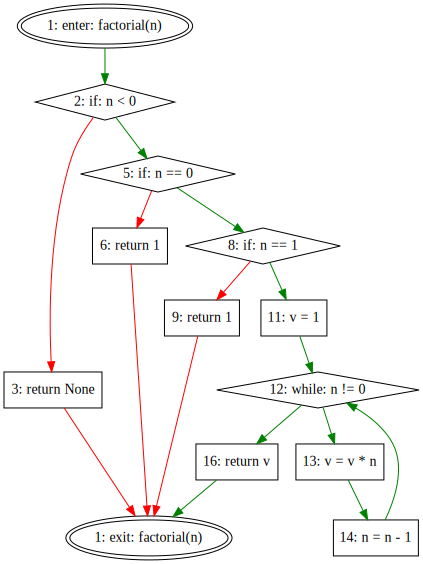

In [11]:
to_graph(gen_cfg(inspect.getsource(factorial)), arcs=cov.arcs())

We see that the path `[1, 2, 5, 8, 11, 12, 13, 14]` is covered (green) but sub-paths such as  `[2, 3]`,  `[5, 6]` and `[8, 9]` are unexplored (red). What we need is the ability to generate inputs such that the `True` branch is taken at `2`. How do we do that?

## Concolic Execution

One way to cover additional branches is to look at the execution path being taken, and collect the _conditional constraints_ that the path encounters. Then we can try to produce inputs that lead us to taking the non-traversed path.

First, let us step through the function.

In [12]:
lines = [i[1] for i in cov._trace if i[0] == 'factorial']
src = {i + 1: s for i, s in enumerate(
    inspect.getsource(factorial).split('\n'))}

* The line (1) is simply the entry point of the function. We know that the input is `n`, which is an integer.

In [13]:
src[1]

'def factorial(n):'

* The line (2) is a predicate `n < 0`. Since the next line taken is line (5), we know that at this point in the execution path, the predicate was `false`.

In [14]:
src[2], src[3], src[4], src[5]

('    if n < 0:', '        return None', '', '    if n == 0:')

We notice that this is one of the predicates where the `true` branch was not taken. How do we generate a value that takes the `true` branch here? One way is to use symbolic variables to represent the input, encode the constraint, and use an *SMT Solver* to solve the negation of the constraint.

As we mentioned in the introduction to the chapter, a symbolic variable can be thought of as a sort of placeholder for the real variable, sort of like the `x` in solving for `x` in Algebra. These variables can be used to encode constraints placed on the variables in the program. We identify what constraints the variable is supposed to obey, and finally produce a value that obeys all constraints imposed.

## Solving Constraints

To solve these constraints, one can use a _Satisfiability Modulo Theories_ (SMT) solver. An SMT solver is built on top of a _SATISFIABILITY_ (SAT) solver. A SAT solver is being used to check whether boolean formulas in first order logic (e.g `(a | b ) & (~a | ~b)`) can be satisfied using any assignments for the variables (e.g `a = true, b = false`). An SMT solver extends these SAT solvers to specific background theories -- for example, _theory of integers_, or _theory of strings_. That is, given a string constraint expressed as a formula with string variables (e.g `h + t == 'hello,world'`), an SMT solver that understands _theory of strings_ can be used to check if that constraint can be satisfied, and if satisfiable, provide an instantiation of concrete values for the variables used in the formula (e.g `h = 'hello,', t = 'world'`).

We use the SMT solver Z3 in this chapter.

In [15]:
import z3  # type: ignore

In [16]:
z3_ver = z3.get_version()

In [17]:
print(z3_ver)

(4, 8, 14, 0)


In [18]:
assert z3_ver >= (4, 8, 13, 0), \
    f"Please install z3-solver 4.8.13.0 or later - you have {z3_ver}"

Let us set up Z3 first. To ensure that the string constraints we use in this chapter are successfully evaluated, we need to specify the `z3str3` solver. Further, we set the timeout for Z3 computations to 30 seconds.

In [19]:
# z3.set_option('smt.string_solver', 'z3str3')
z3.set_option('timeout', 30 * 1000)  # milliseconds

To encode constraints, we need symbolic variables. Here, we make `zn` a placeholder for the Z3 symbolic integer variable `n`.

In [20]:
zn = z3.Int('n')

Remember the constraint `(n < 0)` from line 2 in `factorial()`? We can now encode the constraint as follows. 

In [21]:
zn < 0

n < 0

We previously traced `factorial(5)`. We saw that with input `5`, the execution took the `else` branch on the predicate `n < 0`. We can express this observation as follows.

In [22]:
z3.Not(zn < 0)

Not(n < 0)

Let us now solve constraints. The `z3.solve()` method checks if the constraints are satisfiable; if they are, it also provides values for variables such that the constraints are satisfied. For example, we can ask Z3 for an input that will take the `else` branch as follows:

In [23]:
z3.solve(z3.Not(zn < 0))

[n = 0]


This is *a solution* (albeit a trivial one). SMT solvers can be used to solve much harder problems. For example, here is how one can solve a quadratic equation.

In [24]:
x = z3.Real('x')
eqn = (2 * x**2 - 11 * x + 5 == 0)
z3.solve(eqn)

[x = 5]


Again, this is _one solution_. We can ask z3 to give us another solution as follows.

In [25]:
z3.solve(x != 5, eqn)

[x = 1/2]


Indeed, both `x = 5` and `x = 1/2` are solutions to the quadratic equation $ 2x^2 -11x + 5 = 0 $

Similarly, we can ask *Z3* for an input that satisfies the constraint encoded in line 2 of `factorial()` so that we take the `if` branch.

In [26]:
z3.solve(zn < 0)

[n = -1]


That is, if one uses `-1` as an input to `factorial()`, it is guaranteed to take the `if` branch in line 2 during execution.

Let us try using that with our coverage. Here, the `-1` is the solution from above.

In [27]:
with cov as cov:
    factorial(-1)

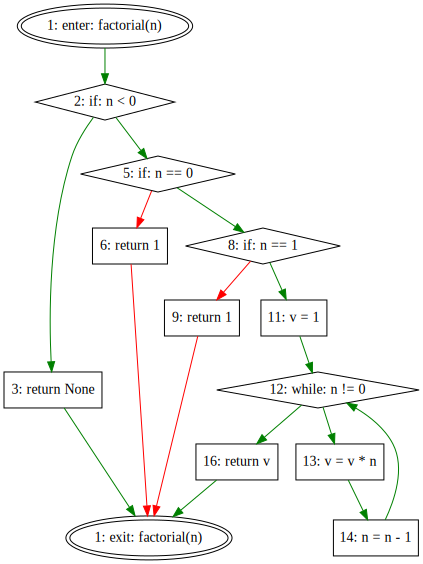

In [28]:
to_graph(gen_cfg(inspect.getsource(factorial)), arcs=cov.arcs())

Ok, so we have managed to cover a little more of the graph. Let us continue with our original input of `factorial(5)`:
* In line (5) we encounter a new predicate `n == 0`, for which we again took the false branch.

In [29]:
src[5]

'    if n == 0:'

The predicates required, to follow the path until this point are as follows.

In [30]:
predicates = [z3.Not(zn < 0), z3.Not(zn == 0)]

* If we continue to line (8), we encounter another predicate, for which again, we took the `false` branch

In [31]:
src[8]

'    if n == 1:'

The predicates encountered so far are as follows

In [32]:
predicates = [z3.Not(zn < 0), z3.Not(zn == 0), z3.Not(zn == 1)]

To take the branch at (6), we essentially have to obey the predicates until that point, but invert the last predicate.

In [33]:
last = len(predicates) - 1
z3.solve(predicates[0:-1] + [z3.Not(predicates[-1])])

[n = 1]


What we are doing here is tracing the execution corresponding to a particular input `factorial(5)`, using concrete values, and along with it, keeping *symbolic shadow variables* that enable us to capture the constraints. As we mentioned in the introduction, this particular method of execution where one tracks concrete  execution using symbolic variables is called *Concolic Execution*.

How do we automate this process? One method is to use a similar infrastructure as that of the chapter on [information flow](InformationFlow.ipynb), and use the Python inheritance to create _symbolic proxy objects_ that can track the concrete execution.

## A Concolic Tracer

Let us now define a class to _collect_ symbolic variables and path conditions during an execution. The idea is to have a `ConcolicTracer` class that is invoked in a `with` block. To execute a function while tracing its path conditions, we need to _transform_ its arguments, which we do by invoking functions through a `[]` item access.

This is a typical usage of a `ConcolicTracer`:

```python
with ConcolicTracer as _:
    _.[function](args, ...)
```

After execution, we can access the symbolic variables in the `decls` attribute:

```python
_.decls
```

whereas the `path` attribute lists the precondition paths encountered:

```python
_.path
```

The `context` attribute contains a pair of declarations and paths:

```python
_.context
```

If you read this for the first time, skip the implementation and head right to the examples.

### Excursion: Implementing ConcolicTracer

Let us now implement `ConcolicTracer`
 constructor of a  accepts a single `context` argument which contains the declarations for the symbolic variables seen so far, and path conditions seen so far. We only need this in case of nested contexts.

In [34]:
class ConcolicTracer:
    """Trace function execution, tracking variables and path conditions"""

    def __init__(self, context=None):
        """Constructor."""
        self.context = context if context is not None else ({}, [])
        self.decls, self.path = self.context

We add the enter and exit methods for the `with` block.

In [35]:
class ConcolicTracer(ConcolicTracer):
    def __enter__(self):
        return self

    def __exit__(self, exc_type, exc_value, tb):
        return

We use introspection to determine the arguments to the function, which is hooked into the `getitem()` method.

In [36]:
class ConcolicTracer(ConcolicTracer):
    def __getitem__(self, fn):
        self.fn = fn
        self.fn_args = {i: None for i in inspect.signature(fn).parameters}
        return self

Finally, the function itself is invoked using the `call` method.

In [37]:
class ConcolicTracer(ConcolicTracer):
    def __call__(self, *args):
        self.result = self.fn(*self.concolic(args))
        return self.result

For now, we define `concolic()` as a transparent function. It will be modified to produce symbolic variables later.

In [38]:
class ConcolicTracer(ConcolicTracer):
    def concolic(self, args):
        return args

We now have things in place for _tracing_ functions:

In [39]:
with ConcolicTracer() as _:
    _[factorial](1)

And for retrieving results (but not actually _computing_ them):

In [40]:
_.decls

{}

In [41]:
_.path

[]

Both `decls` and `path` attributes will be set by concolic proxy objects, which we define next.

#### Concolic Proxy Objects

We now define the concolic proxy objects that can be used for concolic tracing. First, we define the `zproxy_create()` method that given a class name, correctly creates an instance of that class, and the symbolic corresponding variable, and registers the symbolic variable in the context information `context`.

In [42]:
def zproxy_create(cls, z_type, z3var, context, z_name, v=None):
    z_value = cls(context, z3var(z_name), v)
    context[0][z_name] = z_type  # add to decls
    return z_value

#### A Proxy Class for Booleans

First, we define the `zbool` class which is used to track the predicates encountered. It is a wrapper class that contains both symbolic (`z`) as well as concrete (`v`) values. The concrete value is used to determine which path to take, and the symbolic value is used to collect the predicates encountered.

The initialization is done in two parts. The first one is using `zproxy_create()` to correctly initialize and register the shadow symbolic variable corresponding to the passed argument. This is used exclusively when the symbolic variable needs to be initialized first. In all other cases, the constructor is called with the preexisting symbolic value.

In [43]:
class zbool:
    @classmethod
    def create(cls, context, z_name, v):
        return zproxy_create(cls, 'Bool', z3.Bool, context, z_name, v)

    def __init__(self, context, z, v=None):
        self.context = context
        self.z = z
        self.v = v
        self.decl, self.path = self.context

Here is how it is used. We create a symbolic variable `my_bool_arg` with a value of `True` in the current context of the concolic tracer:

In [44]:
with ConcolicTracer() as _:
    val = zbool.create(_.context, 'my_bool_arg', True)

We can now access the symbolic name in the `z` attribute:

In [45]:
val.z

my_bool_arg

The value is in the `v` attribute:

In [46]:
val.v

True

Note that the context of the enclosing `ConcolicTracer()` is automatically updated (via `zproxy_create()`) to hold the variable declarations and types:

In [47]:
_.context

({'my_bool_arg': 'Bool'}, [])

The context can also be reached through the `context` attribute; both point to the same data structure.

In [48]:
val.context

({'my_bool_arg': 'Bool'}, [])

##### Negation of Encoded formula

The `zbool` class allows negation of its concrete and symbolic values.

In [49]:
class zbool(zbool):
    def __not__(self):
        return zbool(self.context, z3.Not(self.z), not self.v)

Here is how it can be used.

In [50]:
with ConcolicTracer() as _:
    val = zbool.create(_.context, 'my_bool_arg', True).__not__()

In [51]:
val.z

Not(my_bool_arg)

In [52]:
val.v

False

In [53]:
_.context

({'my_bool_arg': 'Bool'}, [])

##### Registering Predicates on Conditionals

The `zbool` class is being used to track Boolean conditions that arise during program execution. It tracks such conditions by registering the corresponding symbolic expressions in the context as soon as it is evaluated. On evaluation, the `__bool__()` method is called; so we can hook into this one:

In [54]:
class zbool(zbool):
    def __bool__(self):
        r, pred = (True, self.z) if self.v else (False, z3.Not(self.z))
        self.path.append(pred)
        return r

The `zbool` class can be used to keep track of Boolean values and conditions encountered during the execution. For example, we can encode the conditions encountered by Line 6 in `factorial()` as follows:

First, we define the concrete value (`ca`), and its shadow symbolic variable (`za`).

In [55]:
ca = 5
za = z3.Int('a')

Then, we wrap it in `zbool`, and use it in a conditional, forcing the conditional to be registered in the context.

In [56]:
with ConcolicTracer() as _:
    if zbool(_.context, za == z3.IntVal(5), ca == 5):
        print('success')

success


We can retrieve the registered conditional as follows.

In [57]:
_.path

[5 == a]

#### A Proxy Class for Integers

Next, we define a symbolic wrapper `zint` for `int`.
This class keeps track of the `int` variables used and the predicates encountered in `context`. Finally, it also keeps the concrete value so that it can be used to determine the path to take. As the `zint` extends the primitive `int` class, we have to define a _new_ method to open it for extension.

In [58]:
class zint(int):
    def __new__(cls, context, zn, v, *args, **kw):
        return int.__new__(cls, v, *args, **kw)

As in the case of `zbool`, the initialization takes place in two parts. The first using `create()` if a new symbolic argument is being registered, and then the usual initialization.

In [59]:
class zint(zint):
    @classmethod
    def create(cls, context, zn, v=None):
        return zproxy_create(cls, 'Int', z3.Int, context, zn, v)

    def __init__(self, context, z, v=None):
        self.z, self.v = z, v
        self.context = context

The `int` value of a `zint` object is its concrete value.

In [60]:
class zint(zint):
    def __int__(self):
        return self.v

    def __pos__(self):
        return self.v

Using these proxies is as follows.

In [61]:
with ConcolicTracer() as _:
    val = zint.create(_.context, 'int_arg', 0)

In [62]:
val.z

int_arg

In [63]:
val.v

0

In [64]:
_.context

({'int_arg': 'Int'}, [])

The `zint` class is often used to do arithmetic with, or compare to other `int`s. These `int`s can be either a variable or a constant value. We define a helper method `_zv()` that checks what kind of `int` a given value is, and produces the correct symbolic equivalent.

In [65]:
class zint(zint):
    def _zv(self, o):
        return (o.z, o.v) if isinstance(o, zint) else (z3.IntVal(o), o)

It can be used as follows

In [66]:
with ConcolicTracer() as _:
    val = zint.create(_.context, 'int_arg', 0)

In [67]:
val._zv(0)

(0, 0)

In [68]:
val._zv(val)

(int_arg, 0)

##### Equality between Integers

Two integers can be compared for equality using _ne_ and _eq_.

In [69]:
class zint(zint):
    def __ne__(self, other):
        z, v = self._zv(other)
        return zbool(self.context, self.z != z, self.v != v)

    def __eq__(self, other):
        z, v = self._zv(other)
        return zbool(self.context, self.z == z, self.v == v)

 We also define _req_ using _eq_ in case the int being compared is on the left hand side.

In [70]:
class zint(zint):
    def __req__(self, other):
        return self.__eq__(other)

It can be used as follows.

In [71]:
with ConcolicTracer() as _:
    ia = zint.create(_.context, 'int_a', 0)
    ib = zint.create(_.context, 'int_b', 0)
    v1 = ia == ib
    v2 = ia != ib
    v3 = 0 != ib
    print(v1.z, v2.z, v3.z)

int_a == int_b int_a != int_b 0 != int_b


##### Comparisons between Integers

Integers can also be compared for ordering, and the methods for this are defined below.

In [72]:
class zint(zint):
    def __lt__(self, other):
        z, v = self._zv(other)
        return zbool(self.context, self.z < z, self.v < v)

    def __gt__(self, other):
        z, v = self._zv(other)
        return zbool(self.context, self.z > z, self.v > v)

We use the comparisons and equality operators to provide the other missing operators.

In [73]:
class zint(zint):
    def __le__(self, other):
        z, v = self._zv(other)
        return zbool(self.context, z3.Or(self.z < z, self.z == z),
                     self.v < v or self.v == v)

    def __ge__(self, other):
        z, v = self._zv(other)
        return zbool(self.context, z3.Or(self.z > z, self.z == z),
                     self.v > v or self.v == v)

These functions can be used as follows.

In [74]:
with ConcolicTracer() as _:
    ia = zint.create(_.context, 'int_a', 0)
    ib = zint.create(_.context, 'int_b', 1)
    v1 = ia > ib
    v2 = ia < ib
    print(v1.z, v2.z)
    v3 = ia >= ib
    v4 = ia <= ib
    print(v3.z, v4.z)

int_a > int_b int_a < int_b
Or(int_a > int_b, int_a == int_b) Or(int_a < int_b, int_a == int_b)


##### Binary Operators for Integers

We implement relevant arithmetic operators for integers as described in the [Python documentation](https://docs.python.org/3/reference/datamodel.html#object.__add__). (The commented out operators are not directly available for `z3.ArithRef`. They need to be implemented separately if needed. See the exercises for how it can be done.)

In [75]:
INT_BINARY_OPS = [
    '__add__',
    '__sub__',
    '__mul__',
    '__truediv__',
    # '__div__',
    '__mod__',
    # '__divmod__',
    '__pow__',
    # '__lshift__',
    # '__rshift__',
    # '__and__',
    # '__xor__',
    # '__or__',
    '__radd__',
    '__rsub__',
    '__rmul__',
    '__rtruediv__',
    # '__rdiv__',
    '__rmod__',
    # '__rdivmod__',
    '__rpow__',
    # '__rlshift__',
    # '__rrshift__',
    # '__rand__',
    # '__rxor__',
    # '__ror__',
]

In [76]:
def make_int_binary_wrapper(fname, fun, zfun):  # type: ignore
    def proxy(self, other):
        z, v = self._zv(other)
        z_ = zfun(self.z, z)
        v_ = fun(self.v, v)
        if isinstance(v_, float):
            # we do not implement float results yet.
            assert round(v_) == v_
            v_ = round(v_)
        return zint(self.context, z_, v_)

    return proxy

In [77]:
INITIALIZER_LIST: List[Callable] = []

In [78]:
def initialize():
    for fn in INITIALIZER_LIST:
        fn()

In [79]:
def init_concolic_1():
    for fname in INT_BINARY_OPS:
        fun = getattr(int, fname)
        zfun = getattr(z3.ArithRef, fname)
        setattr(zint, fname, make_int_binary_wrapper(fname, fun, zfun))

In [80]:
INITIALIZER_LIST.append(init_concolic_1)

In [81]:
init_concolic_1()

In [82]:
with ConcolicTracer() as _:
    ia = zint.create(_.context, 'int_a', 0)
    ib = zint.create(_.context, 'int_b', 1)
    print((ia + ib).z)
    print((ia + 10).z)
    print((11 + ib).z)
    print((ia - ib).z)
    print((ia * ib).z)
    print((ia / ib).z)
    print((ia ** ib).z)

int_a + int_b
int_a + 10
11 + int_b
int_a - int_b
int_a*int_b
int_a/int_b
int_a**int_b


##### Integer Unary Operators

We also implement the relevant unary operators as below.

In [83]:
INT_UNARY_OPS = [
    '__neg__',
    '__pos__',
    # '__abs__',
    # '__invert__',
    # '__round__',
    # '__ceil__',
    # '__floor__',
    # '__trunc__',
]

In [84]:
def make_int_unary_wrapper(fname, fun, zfun):
    def proxy(self):
        return zint(self.context, zfun(self.z), fun(self.v))

    return proxy

In [85]:
def init_concolic_2():
    for fname in INT_UNARY_OPS:
        fun = getattr(int, fname)
        zfun = getattr(z3.ArithRef, fname)
        setattr(zint, fname, make_int_unary_wrapper(fname, fun, zfun))

In [86]:
INITIALIZER_LIST.append(init_concolic_2)

In [87]:
init_concolic_2()

We can use the unary operators we defined above as follows:

In [88]:
with ConcolicTracer() as _:
    ia = zint.create(_.context, 'int_a', 0)
    print((-ia).z)
    print((+ia).z)

-int_a
int_a


##### Using an Integer in a Boolean Context

An integer may be converted to a boolean context in conditionals or as part of boolean predicates such as `or`, `and` and `not`. In these cases, the `__bool__()` method gets called. Unfortunately, this method requires a primitive boolean value. Hence, we force the current integer formula to a boolean predicate and register it in the current context.

In [89]:
class zint(zint):
    def __bool__(self):
        # return zbool(self.context, self.z, self.v) <-- not allowed
        # force registering boolean condition
        if self != 0:
            return True
        return False

It is used as follows

In [90]:
with ConcolicTracer() as _:
    za = zint.create(_.context, 'int_a', 1)
    zb = zint.create(_.context, 'int_b', 0)
    if za and zb:
        print(1)

In [91]:
_.context

({'int_a': 'Int', 'int_b': 'Int'}, [0 != int_a, Not(0 != int_b)])

#### Remaining Methods of the  ConcolicTracer

We now complete some of the methods of the `ConcolicTracer`.

##### Translating to the SMT Expression Format

Given that we are using an SMT Solver z3, it is often useful to retrieve the corresponding SMT expression for a symbolic expression. This can be used as an argument to `z3` or other SMT solvers.

The format of the SMT expression ([SMT-LIB](http://smtlib.github.io/jSMTLIB/SMTLIBTutorial.pdf)) is as follows:

* Variables declarations in [S-EXP](https://en.wikipedia.org/wiki/S-expression) format.
  E.g. The following declares a symbolic integer variable `x`
```
(declare-const x Int)
```
 This declares a `bit vector` `b` of length `8`
```
(declare-const b (_ BitVec 8))
```
 This declares a symbolic real variable `r`
```
(declare-const x Real)
```
 This declares a symbolic string variable `s`
```
(declare-const s String)
```

The declared variables can be used in logical formulas that are encoded in *S-EXP* format. For example, here is a logical formula.

```
(assert
    (and
        (= a b)
        (= a c)
        (! b c)))
```
Here is another example, using string variables.

```
(or (< 0 (str.indexof (str.substr my_str1 7 19) " where " 0))
    (= (str.indexof (str.substr my_str1 7 19) " where " 0) 0))
```


In [92]:
class ConcolicTracer(ConcolicTracer):
    def smt_expr(self, show_decl=False, simplify=False, path=[]):
        r = []
        if show_decl:
            for decl in self.decls:
                v = self.decls[decl]
                v = '(_ BitVec 8)' if v == 'BitVec' else v
                r.append("(declare-const %s %s)" % (decl, v))
        path = path if path else self.path
        if path:
            path = z3.And(path)
            if show_decl:
                if simplify:
                    return '\n'.join([
                        *r,
                        "(assert %s)" % z3.simplify(path).sexpr()
                    ])
                else:
                    return '\n'.join(
                        [*r, "(assert %s)" % path.sexpr()])
            else:
                return z3.simplify(path).sexpr()
        else:
            return ''

To see how to use `smt_expr()`, let us consider an example. The `triangle()` function is used to determine if the given sides to a triangle result in an `equilateral` triangle, an `isosceles` triangle, or a `scalene` triangle. It is implemented as follows.

In [93]:
def triangle(a, b, c):
    if a == b:
        if b == c:
            return 'equilateral'
        else:
            return 'isosceles'
    else:
        if b == c:
            return 'isosceles'
        else:
            if a == c:
                return 'isosceles'
            else:
                return 'scalene'

In [94]:
triangle(1, 2, 1)

'isosceles'

To make `triangle()` run under `ConcolicTracer`, we first define the (symbolic) arguments. The triangle being defined has sides `1, 1, 1`. i.e. it is an `equilateral` triangle.

In [95]:
with ConcolicTracer() as _:
    za = zint.create(_.context, 'int_a', 1)
    zb = zint.create(_.context, 'int_b', 1)
    zc = zint.create(_.context, 'int_c', 1)
    triangle(za, zb, zc)
print(_.context)

({'int_a': 'Int', 'int_b': 'Int', 'int_c': 'Int'}, [int_a == int_b, int_b == int_c])


We can now call `smt_expr()` to retrieve the SMT expression as below.

In [96]:
print(_.smt_expr(show_decl=True))

(declare-const int_a Int)
(declare-const int_b Int)
(declare-const int_c Int)
(assert (and (= int_a int_b) (= int_b int_c)))


The collected predicates can also be solved directly using the Python z3 API.

In [97]:
z3.solve(_.path)

[int_c = 0, int_a = 0, int_b = 0]


##### Generating Fresh Names
While using the proxy classes, we often will have to generate new symbolic variables, with names that have not been used before. For this, we define `fresh_name()` that always generates unique integers for names.

In [98]:
COUNTER = 0

In [99]:
def fresh_name():
    global COUNTER
    COUNTER += 1
    return COUNTER

It can be used as follows:

In [100]:
fresh_name()

1

In [101]:
def reset_counter():
    global COUNTER
    COUNTER = 0

In [102]:
class ConcolicTracer(ConcolicTracer):
    def __enter__(self):
        reset_counter()
        return self

    def __exit__(self, exc_type, exc_value, tb):
        return

 ##### Translating Arguments to Concolic Proxies
 
We had previously defined `concolic()` as a transparent function. We now provide the full implementation of this function. It inspects a given function's parameters, and infers the parameter types from the concrete arguments passed in. It then uses this information to instantiate the correct proxy classes for each argument.

In [103]:
class ConcolicTracer(ConcolicTracer):
    def concolic(self, args):
        my_args = []
        for name, arg in zip(self.fn_args, args):
            t = type(arg).__name__
            zwrap = globals()['z' + t]
            vname = "%s_%s_%s_%s" % (self.fn.__name__, name, t, fresh_name())
            my_args.append(zwrap.create(self.context, vname, arg))
            self.fn_args[name] = vname
        return my_args

This is how it gets used:

In [104]:
with ConcolicTracer() as _:
    _[factorial](5)

With the new `concolic()` method, the arguments to the factorial are correctly associated with symbolic variables, which allows us to retrieve the predicates encountered.

In [105]:
_.context

({'factorial_n_int_1': 'Int'},
 [Not(0 > factorial_n_int_1),
  Not(0 == factorial_n_int_1),
  Not(1 == factorial_n_int_1),
  0 != factorial_n_int_1,
  0 != factorial_n_int_1 - 1,
  0 != factorial_n_int_1 - 1 - 1,
  0 != factorial_n_int_1 - 1 - 1 - 1,
  0 != factorial_n_int_1 - 1 - 1 - 1 - 1,
  Not(0 != factorial_n_int_1 - 1 - 1 - 1 - 1 - 1)])

As before, we can also print out the SMT expression which can be passed directly to command line SMT solvers.

In [106]:
print(_.smt_expr(show_decl=True))

(declare-const factorial_n_int_1 Int)
(assert (let ((a!1 (distinct 0 (- (- (- factorial_n_int_1 1) 1) 1)))
      (a!2 (- (- (- (- factorial_n_int_1 1) 1) 1) 1)))
  (and (not (> 0 factorial_n_int_1))
       (not (= 0 factorial_n_int_1))
       (not (= 1 factorial_n_int_1))
       (distinct 0 factorial_n_int_1)
       (distinct 0 (- factorial_n_int_1 1))
       (distinct 0 (- (- factorial_n_int_1 1) 1))
       a!1
       (distinct 0 a!2)
       (not (distinct 0 (- a!2 1))))))


We next define methods to evaluate the SMT expression both in Python and from command line.

##### Evaluating the Concolic Expressions

We define `zeval()` to solve the predicates in a context, and return results. It has two modes. The `python` mode uses `z3` Python API to solve and return the results. If the `python` mode is false, it writes the SMT expression to a file, and invokes the command line `z3` for a solution.

In [107]:
class ConcolicTracer(ConcolicTracer):
    def zeval(self, predicates=None, *,python=False, log=False):
        """Evaluate `predicates` in current context.
        - If `python` is set, use the z3 Python API; otherwise use z3 standalone.
        - If `log` is set, show input to z3.
        Return a pair (`result`, `solution`) where
        - `result` is either `'sat'` (satisfiable); then 
           solution` is a mapping of variables to (value, type) pairs; or
        - `result` is not `'sat'`, indicating an error; then `solution` is `None`
        """
        if predicates is None:
            path = self.path
        else:
            path = list(self.path)
            for i in sorted(predicates):
                if len(path) > i:
                    path[i] = predicates[i]
                else:
                    path.append(predicates[i])
        if log:
            print('Predicates in path:')
            for i, p in enumerate(path):
                print(i, p)
            print()

        r, sol = (zeval_py if python else zeval_smt)(path, self, log)
        if r == 'sat':
            return r, {k: sol.get(self.fn_args[k], None) for k in self.fn_args}
        else:
            return r, None

##### Using the Python API

Given a set of predicates that the function encountered, and the tracer under which the function was executed, the `zeval_py()` function first declares the relevant symbolic variables, and uses the `z3.Solver()`to provide a set of inputs that would trace the same path through the function.

In [108]:
def zeval_py(path, cc, log):
    for decl in cc.decls:
        if cc.decls[decl] == 'BitVec':
            v = "z3.%s('%s', 8)" % (cc.decls[decl], decl)
        else:
            v = "z3.%s('%s')" % (cc.decls[decl], decl)
        exec(v)
    s = z3.Solver()
    s.add(z3.And(path))
    if s.check() == z3.unsat:
        return 'No Solutions', {}
    elif s.check() == z3.unknown:
        return 'Gave up', None
    assert s.check() == z3.sat
    m = s.model()
    return 'sat', {d.name(): m[d] for d in m.decls()}

It can be used as follows:

In [109]:
with ConcolicTracer() as _:
    _[factorial](5)

In [110]:
_.zeval(python=True)

('sat', {'n': 5})

That is, given the set of constraints, the assignment `n == 5` conforms to all constraints.

##### Using the Command Line

The `zeval_smt()` function writes the SMT expression to the file system, and calls the `z3` SMT solver command line to solve it. The result of SMT expression is again an `sexpr`. Hence, we first define `parse_sexp()` to parse and return the correct values.

In [111]:
import re

In [112]:
import subprocess

In [113]:
SEXPR_TOKEN = r'''(?mx)
    \s*(?:
        (?P<bra>\()|
        (?P<ket>\))|
        (?P<token>[^"()\s]+)|
        (?P<string>"[^"]*")
       )'''

In [114]:
def parse_sexp(sexp):
    stack, res = [], []
    for elements in re.finditer(SEXPR_TOKEN, sexp):
        kind, value = [(t, v) for t, v in elements.groupdict().items() if v][0]
        if kind == 'bra':
            stack.append(res)
            res = []
        elif kind == 'ket':
            last, res = res, stack.pop(-1)
            res.append(last)
        elif kind == 'token':
            res.append(value)
        elif kind == 'string':
            res.append(value[1:-1])
        else:
            assert False
    return res

The `parse_sexp()` function can be used as follows

In [115]:
parse_sexp('abcd (hello 123 (world "hello world"))')

['abcd', ['hello', '123', ['world', 'hello world']]]

We now define `zeval_smt()` which uses the `z3` command line directly, and uses `parse_sexp()` to parse and return the solutions to function arguments if any.

In [116]:
import tempfile
import os

In [117]:
Z3_BINARY = 'z3'  # Z3 binary to invoke

In [118]:
Z3_OPTIONS = '-t:6000'  # Z3 options - a soft timeout of 6000 milliseconds

In [119]:
def zeval_smt(path, cc, log):
    s = cc.smt_expr(True, True, path)

    with tempfile.NamedTemporaryFile(mode='w', suffix='.smt',
                                     delete=False) as f:
        f.write(s + "\n")
        f.write("(check-sat)\n")
        f.write("(get-model)\n")

    if log:
        print(open(f.name).read())

    cmd = f"{Z3_BINARY} {Z3_OPTIONS} {f.name}"
    if log:
        print(cmd)

    output = subprocess.getoutput(cmd)

    os.remove(f.name)

    if log:
        print(output)

    o = parse_sexp(output)
    if not o:
        return 'Gave up', None

    kind = o[0]
    if kind == 'unknown':
        return 'Gave up', None
    elif kind == 'timeout':
        return 'Timeout', None
    elif kind == 'unsat':
        return 'No Solutions', {}

    assert kind == 'sat', kind
    if o[1][0] == 'model': # up to 4.8.8.0
        return 'sat', {i[1]: (i[-1], i[-2]) for i in o[1][1:]}
    else:
        return 'sat', {i[1]: (i[-1], i[-2]) for i in o[1][0:]}

We can now use `zeval()` as follows.

In [120]:
with ConcolicTracer() as _:
    _[factorial](5)

In [121]:
_.zeval(log=True)

Predicates in path:
0 Not(0 > factorial_n_int_1)
1 Not(0 == factorial_n_int_1)
2 Not(1 == factorial_n_int_1)
3 0 != factorial_n_int_1
4 0 != factorial_n_int_1 - 1
5 0 != factorial_n_int_1 - 1 - 1
6 0 != factorial_n_int_1 - 1 - 1 - 1
7 0 != factorial_n_int_1 - 1 - 1 - 1 - 1
8 Not(0 != factorial_n_int_1 - 1 - 1 - 1 - 1 - 1)

(declare-const factorial_n_int_1 Int)
(assert (and (<= 0 factorial_n_int_1)
     (not (= 0 factorial_n_int_1))
     (not (= 1 factorial_n_int_1))
     (not (= 2 factorial_n_int_1))
     (not (= 3 factorial_n_int_1))
     (not (= 4 factorial_n_int_1))
     (= 5 factorial_n_int_1)))
(check-sat)
(get-model)

z3 -t:6000 /var/folders/n2/xd9445p97rb3xh7m1dfx8_4h0006ts/T/tmp162yebwn.smt
sat
(
  (define-fun factorial_n_int_1 () Int
    5)
)


('sat', {'n': ('5', 'Int')})

Indeed, we get similar results (`n == 5`)  from using the command line as from using the Python API.

#### A Proxy Class for Strings

Here, we define the proxy string class `zstr`. First we define our initialization routines. Since `str` is a primitive type, we define `new` to extend it.

In [122]:
class zstr(str):
    def __new__(cls, context, zn, v):
        return str.__new__(cls, v)

As before, initialization proceeds with `create()` and the constructor.

In [123]:
class zstr(zstr):
    @classmethod
    def create(cls, context, zn, v=None):
        return zproxy_create(cls, 'String', z3.String, context, zn, v)

    def __init__(self, context, z, v=None):
        self.context, self.z, self.v = context, z, v
        self._len = zint(context, z3.Length(z), len(v))
        #self.context[1].append(z3.Length(z) == z3.IntVal(len(v)))

We also define `_zv()` helper to help us with methods that accept another string

In [124]:
class zstr(zstr):
    def _zv(self, o):
        return (o.z, o.v) if isinstance(o, zstr) else (z3.StringVal(o), o)

### Hack to use the ASCII value of a character.

**Note:** Temporary solution; This block should go away as soon as [this commit](https://github.com/Z3Prover/z3/issues/5764)
is released, which allows us to use the Python API directly.

In [125]:
from typing import Union, Optional, Dict, Generator, Set

def visit_z3_expr(
        e: Union[z3.ExprRef, z3.QuantifierRef],
        seen: Optional[Dict[Union[z3.ExprRef, z3.QuantifierRef], bool]] = None) -> \
        Generator[Union[z3.ExprRef, z3.QuantifierRef], None, None]:
    if seen is None:
        seen = {}
    elif e in seen:
        return

    seen[e] = True
    yield e

    if z3.is_app(e):
        for ch in e.children():
            for e in visit_z3_expr(ch, seen):
                yield e
        return

    if z3.is_quantifier(e):
        for e in visit_z3_expr(e.body(), seen):
            yield e
        return


def is_z3_var(e: z3.ExprRef) -> bool:
    return z3.is_const(e) and e.decl().kind() == z3.Z3_OP_UNINTERPRETED


def get_all_vars(e: z3.ExprRef) -> Set[z3.ExprRef]:
    return {sub for sub in visit_z3_expr(e) if is_z3_var(sub)}


def z3_ord(str_expr: z3.SeqRef) -> z3.ArithRef:
    return z3.parse_smt2_string(
        f"(assert (= 42 (str.to_code {str_expr.sexpr()})))",
        decls={str(c): c for c in get_all_vars(str_expr)}
    )[0].children()[1]


def z3_chr(int_expr: z3.ArithRef) -> z3.SeqRef:
    return z3.parse_smt2_string(
        f"(assert (= \"4\" (str.from_code {int_expr.sexpr()})))",
        decls={str(c): c for c in get_all_vars(int_expr)}
    )[0].children()[1]

##### Retrieving Ordinal Value
We define `zord` that given a symbolic one character long string, obtains the `ord()` for that.

In [126]:
def zord(context, c):
    return z3_ord(c)

We use it as follows

In [127]:
zc = z3.String('arg_%d' % fresh_name())

In [128]:
with ConcolicTracer() as _:
    zi = zord(_.context, zc)

No new variables are defined.

In [129]:
_.context

({}, [])

Here is the smtlib representation.

In [130]:
zi.sexpr()

'(str.to_code arg_2)'

We can specify what the result of `ord()` should be, and call `z3.solve()` to provide us with a solution that will provide the required result.

In [131]:
(zi == 65).sexpr()

'(= (str.to_code arg_2) 65)'

In [132]:
z3.solve([zi == 65])

[arg_2 = "A"]


##### Translating an Ordinal Value to ASCII
Similarly, we can convert the ASCII value back to a single character string using `zchr()`

In [133]:
def zchr(context, i):
    return z3_chr(i)

For using it, we first define a bitvector that is 8 bits long.

In [134]:
i = z3.Int('ival_%d' % fresh_name())

We can now retrieve the `chr()` representation as below.

In [135]:
with ConcolicTracer() as _:
    zc = zchr(_.context, i)

No new variables are defined.

In [136]:
_.context

({}, [])

In [137]:
(zc== z3.StringVal('a')).sexpr()

'(= (str.from_code ival_1) "a")'

As before, we can specify what the end result of calling `chr()` should be to get the original argument.

In [138]:
z3.solve([zc == z3.StringVal('a')])

[ival_1 = 97]


##### Equality between Strings

The equality of `zstr` is defined similar to that of `zint`

In [139]:
class zstr(zstr):
    def __eq__(self, other):
        z, v = self._zv(other)
        return zbool(self.context, self.z == z, self.v == v)

    def __req__(self, other):
        return self.__eq__(other)

The `zstr` class is used as follows.

In [140]:
def tstr1(s):
    if s == 'h':
        return True
    else:
        return False

In [141]:
with ConcolicTracer() as _:
    r = _[tstr1]('h')

In [142]:
_.zeval()

('sat', {'s': ('h', 'String')})

It works even if we have more than one character.

In [143]:
def tstr1(s):  # type: ignore
    if s == 'hello world':
        return True
    else:
        return False

In [144]:
with ConcolicTracer() as _:
    r = _[tstr1]('hello world')

In [145]:
_.context

({'tstr1_s_str_1': 'String'}, [tstr1_s_str_1 == "hello world"])

In [146]:
_.zeval()

('sat', {'s': ('hello world', 'String')})

##### Length of Strings

Unfortunately, in Python, we can't override `len()` to return a new datatype. Hence, we work around that.

In [147]:
class zstr(zstr):
    def __len__(self):
        raise NotImplemented()

In [148]:
class zstr(zstr):
    def length(self):
        return self._len

In [149]:
with ConcolicTracer() as _:
    za = zstr.create(_.context, 'str_a', "s")
    if za.length() > 0:
        print(1)

1


In [150]:
_.context

({'str_a': 'String'}, [0 < Length(str_a)])

In [151]:
def tstr2(s):
    if s.length() > 1:
        return True
    else:
        return False

In [152]:
with ConcolicTracer() as _:
    r = _[tstr2]('hello world')

In [153]:
_.context

({'tstr2_s_str_1': 'String'}, [1 < Length(tstr2_s_str_1)])

In [154]:
_.zeval(log=True)

Predicates in path:
0 1 < Length(tstr2_s_str_1)

(declare-const tstr2_s_str_1 String)
(assert (not (<= (str.len tstr2_s_str_1) 1)))
(check-sat)
(get-model)

z3 -t:6000 /var/folders/n2/xd9445p97rb3xh7m1dfx8_4h0006ts/T/tmpd4f4wb71.smt
sat
(
  (define-fun tstr2_s_str_1 () String
    "AB")
)


('sat', {'s': ('AB', 'String')})

##### Concatenation of Strings
What if we need to concatenate two strings? We need additional helpers to accomplish that.

In [155]:
class zstr(zstr):
    def __add__(self, other):
        z, v = self._zv(other)
        return zstr(self.context, self.z + z, self.v + v)

    def __radd__(self, other):
        return self.__add__(other)

Here is how it can be used. First, we create the wrapped arguments

In [156]:
with ConcolicTracer() as _:
    v1, v2 = [zstr.create(_.context, 'arg_%d' % fresh_name(), s)
              for s in ['hello', 'world']]
    if (v1 + ' ' + v2) == 'hello world':
        print('hello world')

hello world


The addition of symbolic variables is preserved in `context`

In [157]:
_.context

({'arg_1': 'String', 'arg_2': 'String'},
 [Concat(Concat(arg_1, " "), arg_2) == "hello world"])

##### Producing Substrings
Similarly, accessing substrings also require extra help.

In [158]:
class zstr(zstr):
    def __getitem__(self, idx):
        if isinstance(idx, slice):
            start, stop, step = idx.indices(len(self.v))
            assert step == 1  # for now
            assert stop >= start  # for now
            rz = z3.SubString(self.z, start, stop - start)
            rv = self.v[idx]
        elif isinstance(idx, int):
            rz = z3.SubString(self.z, idx, 1)
            rv = self.v[idx]
        else:
            assert False  # for now
        return zstr(self.context, rz, rv)

    def __iter__(self):
        return zstr_iterator(self.context, self)

##### An Iterator Class for Strings

We define the iterator as follows.

In [159]:
class zstr_iterator():
    def __init__(self, context, zstr):
        self.context = context
        self._zstr = zstr
        self._str_idx = 0
        self._str_max = zstr._len  # intz is not an _int_

    def __next__(self):
        if self._str_idx == self._str_max:  # intz#eq
            raise StopIteration
        c = self._zstr[self._str_idx]
        self._str_idx += 1
        return c

    def __len__(self):
        return self._len

Here is how it can be used.

In [160]:
def tstr3(s):
    if s[0] == 'h' and s[1] == 'e' and s[3] == 'l':
        return True
    else:
        return False

In [161]:
with ConcolicTracer() as _:
    r = _[tstr3]('hello')

Again, the context shows predicates encountered.

In [162]:
_.context

({'tstr3_s_str_1': 'String'},
 [str.substr(tstr3_s_str_1, 0, 1) == "h",
  str.substr(tstr3_s_str_1, 1, 1) == "e",
  str.substr(tstr3_s_str_1, 3, 1) == "l"])

The function `zeval()` returns a solution for the predicate. Note that the value returned is not exactly the argument that we passed in. This is a consequence of the predicates we have. That is, we have no constraints on what the character value on `s[2]` should be.

In [163]:
_.zeval()

('sat', {'s': ('heAl', 'String')})

##### Translating to Upper and Lower Equivalents

A major complication is supporting `upper()` and `lower()` methods. We use the previously defined `zchr()` and `zord()` functions to accomplish this.

In [164]:
class zstr(zstr):
    def upper(self):
        empty = ''
        ne = 'empty_%d' % fresh_name()
        result = zstr.create(self.context, ne, empty)
        self.context[1].append(z3.StringVal(empty) == result.z)
        cdiff = (ord('a') - ord('A'))
        for i in self:
            oz = zord(self.context, i.z)
            uz = zchr(self.context, oz - cdiff)
            rz = z3.And([oz >= ord('a'), oz <= ord('z')])
            ov = ord(i.v)
            uv = chr(ov - cdiff)
            rv = ov >= ord('a') and ov <= ord('z')
            if zbool(self.context, rz, rv):
                i = zstr(self.context, uz, uv)
            else:
                i = zstr(self.context, i.z, i.v)
            result += i
        return result

The `lower()` function is similar to `upper()` except that the character ranges are switched, and the lowercase is above uppercase. Hence, we add the difference to the ordinal to make a character to lowercase.

In [165]:
class zstr(zstr):
    def lower(self):
        empty = ''
        ne = 'empty_%d' % fresh_name()
        result = zstr.create(self.context, ne, empty)
        self.context[1].append(z3.StringVal(empty) == result.z)
        cdiff = (ord('a') - ord('A'))
        for i in self:
            oz = zord(self.context, i.z)
            uz = zchr(self.context, oz + cdiff)
            rz = z3.And([oz >= ord('A'), oz <= ord('Z')])
            ov = ord(i.v)
            uv = chr(ov + cdiff)
            rv = ov >= ord('A') and ov <= ord('Z')
            if zbool(self.context, rz, rv):
                i = zstr(self.context, uz, uv)
            else:
                i = zstr(self.context, i.z, i.v)
            result += i
        return result

Here is how `upper()` is used.

In [166]:
def tstr4(s):
    if s.upper() == 'H':
        return True
    else:
        return False

In [167]:
with ConcolicTracer() as _:
    r = _[tstr4]('h')

Again, we use `zeval()` to solve the collected constraints, and verify that our constraints are correct. 

In [168]:
_.zeval()

('sat', {'s': ('h', 'String')})

Here is a larger example using `lower()`:

In [169]:
def tstr5(s):
    if s.lower() == 'hello world':
        return True
    else:
        return False

In [170]:
with ConcolicTracer() as _:
    r = _[tstr5]('Hello World')

In [171]:
_.zeval()

('sat', {'s': ('Hello World', 'String')})

Again, we obtain the right input value.

##### Checking for String Prefixes
We define `startswith()`.

In [172]:
class zstr(zstr):
    def startswith(self, other, beg=0, end=None):
        assert end is None  # for now
        assert isinstance(beg, int)  # for now
        zb = z3.IntVal(beg)

        others = other if isinstance(other, tuple) else (other, )

        last = False
        for o in others:
            z, v = self._zv(o)
            r = z3.IndexOf(self.z, z, zb)
            last = zbool(self.context, r == zb, self.v.startswith(v))
            if last:
                return last
        return last

An example.

In [173]:
def tstr6(s):
    if s.startswith('hello'):
        return True
    else:
        return False

In [174]:
with ConcolicTracer() as _:
    r = _[tstr6]('hello world')

In [175]:
_.zeval()

('sat', {'s': ('helloAhello', 'String')})

In [176]:
with ConcolicTracer() as _:
    r = _[tstr6]('my world')

In [177]:
_.zeval()

('sat', {'s': ('', 'String')})

As before, the predicates only ensure that the `startswith()` returned a true value. Hence, our solution reflects that.

##### Finding Substrings
We also define `find()`

In [178]:
class zstr(zstr):
    def find(self, other, beg=0, end=None):
        assert end is None  # for now
        assert isinstance(beg, int)  # for now
        zb = z3.IntVal(beg)
        z, v = self._zv(other)
        zi = z3.IndexOf(self.z, z, zb)
        vi = self.v.find(v, beg, end)
        return zint(self.context, zi, vi)

An example.

In [179]:
def tstr7(s):
    if s.find('world') != -1:
        return True
    else:
        return False

In [180]:
with ConcolicTracer() as _:
    r = _[tstr7]('hello world')

In [181]:
_.zeval()

('sat', {'s': ('worldAworld', 'String')})

As before, the predicates only ensure that the `find()` returned a value greater than -1. Hence, our solution reflects that.

##### Remove Space from Ends

We next implement `strip()`.

In [182]:
import string

In [183]:
class zstr(zstr):
    def rstrip(self, chars=None):
        if chars is None:
            chars = string.whitespace
        if self._len == 0:
            return self
        else:
            last_idx = self._len - 1
            cz = z3.SubString(self.z, last_idx.z, 1)
            cv = self.v[-1]
            zcheck_space = z3.Or([cz == z3.StringVal(char) for char in chars])
            vcheck_space = any(cv == char for char in chars)
            if zbool(self.context, zcheck_space, vcheck_space):
                return zstr(self.context, z3.SubString(self.z, 0, last_idx.z),
                            self.v[0:-1]).rstrip(chars)
            else:
                return self

In [184]:
def tstr8(s):
    if s.rstrip(' ') == 'a b':
        return True
    else:
        return False

In [185]:
with ConcolicTracer() as _:
    r = _[tstr8]('a b   ')
    print(r)

True


In [186]:
_.zeval()

('sat', {'s': ('a b   ', 'String')})

In [187]:
class zstr(zstr):
    def lstrip(self, chars=None):
        if chars is None:
            chars = string.whitespace
        if self._len == 0:
            return self
        else:
            first_idx = 0
            cz = z3.SubString(self.z, 0, 1)
            cv = self.v[0]
            zcheck_space = z3.Or([cz == z3.StringVal(char) for char in chars])
            vcheck_space = any(cv == char for char in chars)
            if zbool(self.context, zcheck_space, vcheck_space):
                return zstr(self.context, z3.SubString(
                    self.z, 1, self._len.z), self.v[1:]).lstrip(chars)
            else:
                return self

In [188]:
def tstr9(s):
    if s.lstrip(' ') == 'a b':
        return True
    else:
        return False

In [189]:
with ConcolicTracer() as _:
    r = _[tstr9]('   a b')
    print(r)

True


In [190]:
_.zeval()

('sat', {'s': ('   a b', 'String')})

In [191]:
class zstr(zstr):
    def strip(self, chars=None):
        return self.lstrip(chars).rstrip(chars)

Example usage.

In [192]:
def tstr10(s):
    if s.strip() == 'a b':
        return True
    else:
        return False

In [193]:
with ConcolicTracer() as _:
    r = _[tstr10]('    a b  ')
    print(r)

True


In [194]:
_.zeval()

('sat', {'s': ('\\u{a}\\u{a}\\u{9}\\u{a}a b\\u{c}\\u{d}', 'String')})

The `strip()` has generated the right constraints. 

##### Splitting Strings

We implement string `split()` as follows.

In [195]:
class zstr(zstr):
    def split(self, sep=None, maxsplit=-1):
        assert sep is not None  # default space based split is complicated
        assert maxsplit == -1  # for now.
        zsep = z3.StringVal(sep)
        zl = z3.Length(zsep)
        # zi would be the length of prefix
        zi = z3.IndexOf(self.z, zsep, z3.IntVal(0))
        # Z3Bug: There is a bug in the `z3.IndexOf` method which returns
        # `z3.SeqRef` instead of `z3.ArithRef`. So we need to fix it.
        zi = z3.ArithRef(zi.ast, zi.ctx)

        vi = self.v.find(sep)
        if zbool(self.context, zi >= z3.IntVal(0), vi >= 0):
            zprefix = z3.SubString(self.z, z3.IntVal(0), zi)
            zmid = z3.SubString(self.z, zi, zl)
            zsuffix = z3.SubString(self.z, zi + zl,
                                   z3.Length(self.z))
            return [zstr(self.context, zprefix, self.v[0:vi])] + zstr(
                self.context, zsuffix, self.v[vi + len(sep):]).split(
                    sep, maxsplit)
        else:
            return [self]

In [196]:
def tstr11(s):
    if s.split(',') == ['a', 'b', 'c']:
        return True
    else:
        return False

In [197]:
with ConcolicTracer() as _:
    r = _[tstr11]('a,b,c')
    print(r)

True


In [198]:
_.zeval()

('sat', {'s': ('a,b,c', 'String')})

##### Trip Wire

For easier debugging, we abort any calls to methods in `str` that are not overridden by `zstr`.

In [199]:
def make_str_abort_wrapper(fun):
    def proxy(*args, **kwargs):
        raise Exception('%s Not implemented in `zstr`' % fun.__name__)
    return proxy

In [200]:
def init_concolic_3():
    strmembers = inspect.getmembers(zstr, callable)
    zstrmembers = {m[0] for m in strmembers if len(
        m) == 2 and 'zstr' in m[1].__qualname__}
    for name, fn in inspect.getmembers(str, callable):
        # Omitted 'splitlines' as this is needed for formatting output in
        # IPython/Jupyter
        if name not in zstrmembers and name not in [
            'splitlines',
            '__class__',
            '__contains__',
            '__delattr__',
            '__dir__',
            '__format__',
            '__ge__',
            '__getattribute__',
            '__getnewargs__',
            '__gt__',
            '__hash__',
            '__le__',
            '__len__',
            '__lt__',
            '__mod__',
            '__mul__',
            '__ne__',
            '__reduce__',
            '__reduce_ex__',
            '__repr__',
            '__rmod__',
            '__rmul__',
            '__setattr__',
            '__sizeof__',
                '__str__']:
            setattr(zstr, name, make_str_abort_wrapper(fn))

In [201]:
INITIALIZER_LIST.append(init_concolic_3)

In [202]:
init_concolic_3()

### End of Excursion

### Example: Triangle

We previously showed how to run `triangle()` under `ConcolicTracer`.

In [203]:
with ConcolicTracer() as _:
    print(_[triangle](1, 2, 3))

scalene


The symbolic variables are as follows:

In [204]:
_.decls

{'triangle_a_int_1': 'Int',
 'triangle_b_int_2': 'Int',
 'triangle_c_int_3': 'Int'}

The predicates are as follows:

In [205]:
_.path

[Not(triangle_a_int_1 == triangle_b_int_2),
 Not(triangle_b_int_2 == triangle_c_int_3),
 Not(triangle_a_int_1 == triangle_c_int_3)]

Using `zeval()`, we solve these path conditions and obtain a solution. We find that Z3 gives us three distinct integer values:

In [206]:
_.zeval()

('sat',
 {'a': ('0', 'Int'), 'b': (['-', '2'], 'Int'), 'c': (['-', '1'], 'Int')})

(Note that some of the values may be negative. Indeed, `triangle()` works with negative length values, too, even if real triangles only have positive lengths.)

If we invoke `triangle()` with these very values, we take the _exact same path_ as the original input:

In [207]:
triangle(0, -2, -1)

'scalene'

We can have z3 _negate_ individual conditions – and thus take different paths.
First, we retrieve the symbolic variables.

In [208]:
za, zb, zc = [z3.Int(s) for s in _.decls.keys()]

In [209]:
za, zb, zc

(triangle_a_int_1, triangle_b_int_2, triangle_c_int_3)

Then, we pass a negated predicate to `zeval()`. The key (here: `1`) determines which predicate the new predicate will replace.

In [210]:
_.zeval({1: zb == zc})

('sat', {'a': ('1', 'Int'), 'b': ('0', 'Int'), 'c': ('0', 'Int')})

In [211]:
triangle(1, 0, 1)

'isosceles'

The updated predicate returns `isosceles` as expected. By negating further conditions, we can systematically explore all branches in `triangle()`.

### Example: Decoding CGI Strings

Let us apply `ConcolicTracer` on our example program `cgi_decode()` from the [chapter on coverage](Coverage.ipynb). Note that we need to rewrite its code slightly, as the hash lookups in `hex_values` can not be used for transferring constraints yet.

In [212]:
def cgi_decode(s):
    """Decode the CGI-encoded string `s`:
       * replace "+" by " "
       * replace "%xx" by the character with hex number xx.
       Return the decoded string.  Raise `ValueError` for invalid inputs."""

    # Mapping of hex digits to their integer values
    hex_values = {
        '0': 0, '1': 1, '2': 2, '3': 3, '4': 4,
        '5': 5, '6': 6, '7': 7, '8': 8, '9': 9,
        'a': 10, 'b': 11, 'c': 12, 'd': 13, 'e': 14, 'f': 15,
        'A': 10, 'B': 11, 'C': 12, 'D': 13, 'E': 14, 'F': 15,
    }

    t = ''
    i = 0
    while i < s.length():
        c = s[i]
        if c == '+':
            t += ' '
        elif c == '%':
            digit_high, digit_low = s[i + 1], s[i + 2]
            i = i + 2
            found = 0
            v = 0
            for key in hex_values:
                if key == digit_high:
                    found = found + 1
                    v = hex_values[key] * 16
                    break
            for key in hex_values:
                if key == digit_low:
                    found = found + 1
                    v = v + hex_values[key]
                    break
            if found == 2:
                if v >= 128:
                    # z3.StringVal(urllib.parse.unquote('%80')) <-- bug in z3
                    raise ValueError("Invalid encoding")
                t = t + chr(v)
            else:
                raise ValueError("Invalid encoding")
        else:
            t = t + c
        i = i + 1
    return t

In [213]:
with ConcolicTracer() as _:
    _[cgi_decode]('')

In [214]:
_.context

({'cgi_decode_s_str_1': 'String'}, [Not(0 < Length(cgi_decode_s_str_1))])

In [215]:
with ConcolicTracer() as _:
    _[cgi_decode]('a%20d')

Once executed, we can retrieve the symbolic variables in the `decls` attribute. This is a mapping of symbolic variables to types.

In [216]:
_.decls

{'cgi_decode_s_str_1': 'String'}

The extracted path conditions can be found in the `path` attribute:

In [217]:
_.path

[0 < Length(cgi_decode_s_str_1),
 Not(str.substr(cgi_decode_s_str_1, 0, 1) == "+"),
 Not(str.substr(cgi_decode_s_str_1, 0, 1) == "%"),
 1 < Length(cgi_decode_s_str_1),
 Not(str.substr(cgi_decode_s_str_1, 1, 1) == "+"),
 str.substr(cgi_decode_s_str_1, 1, 1) == "%",
 Not(str.substr(cgi_decode_s_str_1, 2, 1) == "0"),
 Not(str.substr(cgi_decode_s_str_1, 2, 1) == "1"),
 str.substr(cgi_decode_s_str_1, 2, 1) == "2",
 str.substr(cgi_decode_s_str_1, 3, 1) == "0",
 4 < Length(cgi_decode_s_str_1),
 Not(str.substr(cgi_decode_s_str_1, 4, 1) == "+"),
 Not(str.substr(cgi_decode_s_str_1, 4, 1) == "%"),
 Not(5 < Length(cgi_decode_s_str_1))]

The `context` attribute holds a pair of `decls` and `path` attributes; this is useful for passing it into the `ConcolicTracer` constructor.

In [218]:
assert _.context == (_.decls, _.path)

We can solve these constraints to obtain a value for the function parameters that follow the same path as the original (traced) invocation:

In [219]:
_.zeval()

('sat', {'s': ('A%20B', 'String')})

_Negating_ some of these constraints will yield different paths taken, and thus greater code coverage. This is what our concolic fuzzers (see later) do. Let us go and negate the first constraint, namely that the first character should _not_ be a `+` character:

In [220]:
_.path[0]

0 < Length(cgi_decode_s_str_1)

To compute the negated string, we have to construct it via z3 primitives:

In [221]:
zs = z3.String('cgi_decode_s_str_1')

In [222]:
z3.SubString(zs, 0, 1) == z3.StringVal('a')

str.substr(cgi_decode_s_str_1, 0, 1) == "a"

Invoking `zeval()` with the path condition to be changed obtains a new input that satisfies the negated predicate:

In [223]:
(result, new_vars) = _.zeval({1: z3.SubString(zs, 0, 1) == z3.StringVal('+')})


In [224]:
new_vars

{'s': ('+%20A', 'String')}

In [225]:
(new_s, new_s_type) = new_vars['s']

In [226]:
new_s

'+%20A'

We can validate that `new_s` indeed takes the new path by re-running the tracer with `new_s` as input:

In [227]:
with ConcolicTracer() as _:
    _[cgi_decode](new_s)

In [228]:
_.path

[0 < Length(cgi_decode_s_str_1),
 str.substr(cgi_decode_s_str_1, 0, 1) == "+",
 1 < Length(cgi_decode_s_str_1),
 Not(str.substr(cgi_decode_s_str_1, 1, 1) == "+"),
 str.substr(cgi_decode_s_str_1, 1, 1) == "%",
 Not(str.substr(cgi_decode_s_str_1, 2, 1) == "0"),
 Not(str.substr(cgi_decode_s_str_1, 2, 1) == "1"),
 str.substr(cgi_decode_s_str_1, 2, 1) == "2",
 str.substr(cgi_decode_s_str_1, 3, 1) == "0",
 4 < Length(cgi_decode_s_str_1),
 Not(str.substr(cgi_decode_s_str_1, 4, 1) == "+"),
 Not(str.substr(cgi_decode_s_str_1, 4, 1) == "%"),
 Not(5 < Length(cgi_decode_s_str_1))]

By negating further conditions, we can explore more and more code.

### Example: Round

Here is a function that gives you the nearest ten's multiplier

In [229]:
def round10(r):
    while r % 10 != 0:
        r += 1
    return r

As before, we execute the function under the `ConcolicTracer` context.

In [230]:
with ConcolicTracer() as _:
    r = _[round10](1)

We verify that we were able to capture all the predicates:

In [231]:
_.context

({'round10_r_int_1': 'Int'},
 [0 != round10_r_int_1%10,
  0 != (round10_r_int_1 + 1)%10,
  0 != (round10_r_int_1 + 1 + 1)%10,
  0 != (round10_r_int_1 + 1 + 1 + 1)%10,
  0 != (round10_r_int_1 + 1 + 1 + 1 + 1)%10,
  0 != (round10_r_int_1 + 1 + 1 + 1 + 1 + 1)%10,
  0 != (round10_r_int_1 + 1 + 1 + 1 + 1 + 1 + 1)%10,
  0 != (round10_r_int_1 + 1 + 1 + 1 + 1 + 1 + 1 + 1)%10,
  0 != (round10_r_int_1 + 1 + 1 + 1 + 1 + 1 + 1 + 1 + 1)%10,
  Not(0 !=
      (round10_r_int_1 + 1 + 1 + 1 + 1 + 1 + 1 + 1 + 1 + 1)%10)])

We use `zeval()` to obtain more inputs that take the same path.

In [232]:
_.zeval()

('sat', {'r': (['-', '9'], 'Int')})

### Example: Absolute Maximum

Do our concolic proxies work across functions? Say we have a function `max_value()` as below.

In [233]:
def abs_value(a):
    if a > 0:
        return a
    else:
        return -a

It is called by another function `abs_max()`

In [234]:
def abs_max(a, b):
    a1 = abs_value(a)
    b1 = abs_value(b)
    if a1 > b1:
        c = a1
    else:
        c = b1
    return c

Using the `Concolic()` context on `abs_max()`.

In [235]:
with ConcolicTracer() as _:
    _[abs_max](2, 1)

As expected, we have the predicates across functions.

In [236]:
_.context

({'abs_max_a_int_1': 'Int', 'abs_max_b_int_2': 'Int'},
 [0 < abs_max_a_int_1, 0 < abs_max_b_int_2, abs_max_a_int_1 > abs_max_b_int_2])

In [237]:
_.zeval()

('sat', {'a': ('2', 'Int'), 'b': ('1', 'Int')})

Solving the predicates works as expected.

Using negative numbers as arguments so that a different branch is taken in `abs_value()`

In [238]:
with ConcolicTracer() as _:
    _[abs_max](-2, -1)

In [239]:
_.context

({'abs_max_a_int_1': 'Int', 'abs_max_b_int_2': 'Int'},
 [Not(0 < abs_max_a_int_1),
  Not(0 < abs_max_b_int_2),
  -abs_max_a_int_1 > -abs_max_b_int_2])

In [240]:
_.zeval()

('sat', {'a': (['-', '1'], 'Int'), 'b': ('0', 'Int')})

The solution reflects our predicates. (We used `a > 0` in `abs_value()`).

### Example: Binomial Coefficient

For a larger example that uses different kinds of variables, say we want to compute the binomial coefficient by the following formulas

$$ 
^nP_k=\frac{n!}{(n-k)!}
$$

$$
\binom nk=\,^nC_k=\frac{^nP_k}{k!}
$$


we define the functions as follows.

In [241]:
def factorial(n):  # type: ignore
    v = 1
    while n != 0:
        v *= n
        n -= 1

    return v

In [242]:
def permutation(n, k):
    return factorial(n) / factorial(n - k)

In [243]:
def combination(n, k):
    return permutation(n, k) / factorial(k)

In [244]:
def binomial(n, k):
    if n < 0 or k < 0 or n < k:
        raise Exception('Invalid values')
    return combination(n, k)

As before, we run the function under `ConcolicTracer`.

In [245]:
with ConcolicTracer() as _:
    v = _[binomial](4, 2)

Then call `zeval()` to evaluate.

In [246]:
_.zeval()

('sat', {'n': ('4', 'Int'), 'k': ('2', 'Int')})

### Example: Database

For a larger example using the Concolic String class `zstr`, we use the DB class from the [chapter on information flow](InformationFlow.ipynb).

In [247]:
if __name__ == '__main__':
    if z3.get_version() > (4, 8, 7, 0):
        print("""Note: The following example may not work with your Z3 version;
see https://github.com/Z3Prover/z3/issues/5763 for details.
Consider `pip install z3-solver==4.8.7.0` as a workaround.""")

Note: The following example may not work with your Z3 version;
see https://github.com/Z3Prover/z3/issues/5763 for details.
Consider `pip install z3-solver==4.8.7.0` as a workaround.


In [248]:
from InformationFlow import DB, sample_db, update_inventory

We first populate our database.

In [249]:
from GrammarMiner import VEHICLES  # minor dependency

In [250]:
db = sample_db()
for V in VEHICLES:
    update_inventory(db, V)

In [251]:
db.db

{'inventory': ({'year': int, 'kind': str, 'company': str, 'model': str},
  [{'year': 1997, 'kind': 'van', 'company': 'Ford', 'model': 'E350'},
   {'year': 2000, 'kind': 'car', 'company': 'Mercury', 'model': 'Cougar'},
   {'year': 1999, 'kind': 'car', 'company': 'Chevy', 'model': 'Venture'}])}

We are now ready to fuzz our `DB` class. Hash functions are difficult to handle directly (because they rely on internal C functions). Hence we modify `table()` slightly.

In [252]:
class ConcolicDB(DB):
    def table(self, t_name):
        for k, v in self.db:
            if t_name == k:
                return v
        raise SQLException('Table (%s) was not found' % repr(t_name))

    def column(self, decl, c_name):
        for k in decl:
            if c_name == k:
                return decl[k]
        raise SQLException('Column (%s) was not found' % repr(c_name))

To make it easy, we define a single function `db_select()` that directly invokes `db.sql()`.

In [253]:
def db_select(s):
    my_db = ConcolicDB()
    my_db.db = [(k, v) for (k, v) in db.db.items()]
    r = my_db.sql(s)
    return r

We now want to run SQL statements under our `ConcolicTracer`, and collect predicates obtained.

In [254]:
with ConcolicTracer() as _:
    _[db_select]('select kind from inventory')

The predicates encountered during the execution are as follows:

In [255]:
_.path

[0 == IndexOf(db_select_s_str_1, "select ", 0),
 0 == IndexOf(db_select_s_str_1, "select ", 0),
 Not(0 >
     IndexOf(str.substr(db_select_s_str_1, 7, 19),
             " from ",
             0)),
 Not(19 <
     IndexOf(str.substr(db_select_s_str_1, 7, 19),
             " from ",
             0)),
 Or(0 <
    IndexOf(str.substr(db_select_s_str_1, 7, 19),
            " from ",
            0),
    0 ==
    IndexOf(str.substr(db_select_s_str_1, 7, 19),
            " from ",
            0)),
 Not(Or(0 <
        IndexOf(str.substr(db_select_s_str_1, 7, 19),
                " where ",
                0),
        0 ==
        IndexOf(str.substr(db_select_s_str_1, 7, 19),
                " where ",
                0))),
 Not(19 <
     IndexOf(str.substr(db_select_s_str_1, 7, 19),
             " from ",
             0) +
     6),
 Or(19 >
    IndexOf(str.substr(db_select_s_str_1, 7, 19),
            " from ",
            0) +
    6,
    19 ==
    IndexOf(str.substr(db_select_s_str_1, 7, 19),
  

We can use `zeval()` as before to solve the constraints.

In [256]:
_.zeval()

('Gave up', None)

## Fuzzing with Constraints

The `SimpleConcolicFuzzer` class starts with a sample input generated by some other fuzzer. It then runs the function being tested under `ConcolicTracer`, and collects the path predicates. It then negates random predicates within the path and solves it with Z3 to produce a new output that is guaranteed to take a different path than the original.

As with `ConcolicTracer`, above, please first look at the examples before digging into the implementation.

### Excursion: Implementing SimpleConcolicFuzzer

First, we import the `Fuzzer` interface, and write example program `hang_if_no_space()`

In [257]:
from Fuzzer import Fuzzer

In [258]:
def hang_if_no_space(s):
    i = 0
    while True:
        if i < s.length():
            if s[i] == ' ':
                break
        i += 1

In [259]:
from ExpectError import ExpectTimeout, ExpectError

In [260]:
import random

#### Representing Decisions

To make the fuzzer work, we need a way to represent decisions made during trace. We keep this in a _binary tree_ where each node represents a decision made, and each leaf represents a complete path. A node in the binary tree is represented by the `TraceNode` class.

When a new node is added, it represents a decision taken by the parent on some predicate. This predicate is supplied as `smt_val`, which is `True` for this child to be reached. Since the predicate is actually present in the parent node, we also carry a member `smt` which will be updated by the first child to be added.

In [261]:
class TraceNode:
    def __init__(self, smt_val, parent, info):
        # This is the smt that lead to this node
        self._smt_val = z3.simplify(smt_val) if smt_val is not None else None

        # This is the predicate that this node might perform at a future point
        self.smt = None
        self.info = info
        self.parent = parent
        self.children = {}
        self.path = None
        self.tree = None
        self._pattern = None
        self.log = True

    def no(self): return self.children.get(self.tree.no_bit)

    def yes(self): return self.children.get(self.tree.yes_bit)

    def get_children(self): return (self.no(), self.yes())

    def __str__(self):
        return 'TraceNode[%s]' % ','.join(self.children.keys())

We add a `PlausibleChild` class to track the leaf nodes.

In [262]:
class PlausibleChild:
    def __init__(self, parent, cond, tree):
        self.parent = parent
        self.cond = cond
        self.tree = tree
        self._smt_val = None

    def __repr__(self):
        return 'PlausibleChild[%s]' % (self.parent.pattern() + ':' + self.cond)

When the leaf nodes are used to generate new paths, we expect its sibling `TraceNode` to have been already explored. Hence, we make use of the sibling's values for context `cc`, and the `smt_val` from the parent.

In [263]:
class PlausibleChild(PlausibleChild):
    def smt_val(self):
        if self._smt_val is not None:
            return self._smt_val
        # if the parent has other children, then that child would have updatd the parent's smt
        # Hence, we can use that child's smt_value's opposite as our value.
        assert self.parent.smt is not None
        if self.cond == self.tree.no_bit:
            self._smt_val = z3.Not(self.parent.smt)
        else:
            self._smt_val = self.parent.smt
        return self._smt_val

    def cc(self):
        if self.parent.info.get('cc') is not None:
            return self.parent.info['cc']
        # if there is a plausible child node, it means that there can
        # be at most one child.
        siblings = list(self.parent.children.values())
        assert len(siblings) == 1
        # We expect at the other child to have cc
        return siblings[0].info['cc']

The `PlausibleChild` instance is used to generate new paths to explore using `path_expression()`.

In [264]:
class PlausibleChild(PlausibleChild):
    def path_expression(self):
        path_to_root = self.parent.get_path_to_root()
        assert path_to_root[0]._smt_val is None
        return [i._smt_val for i in path_to_root[1:]] + [self.smt_val()]

The `TraceTree` class helps us keep track of the binary tree. In the beginning, the root is a sentinel `TraceNode` instance, and simply have two plausible children as leaves. As soon as the first trace is added, one of the plausible children will become a true child.

In [265]:
class TraceTree:
    def __init__(self):
        self.root = TraceNode(smt_val=None, parent=None, info={'num': 0})
        self.root.tree = self
        self.leaves = {}
        self.no_bit, self.yes_bit = '0', '1'

        pprefix = ':'
        for bit in [self.no_bit, self.yes_bit]:
            self.leaves[pprefix + bit] = PlausibleChild(self.root, bit, self)
        self.completed_paths = {}

The `add_trace()` method of the `TraceTree` provides a way for new traces to be added. It is kept separate from the initialization as we might want to add more than one trace from the same function.

In [266]:
class TraceTree(TraceTree):
    def add_trace(self, tracer, string):
        last = self.root
        i = 0
        for i, elt in enumerate(tracer.path):
            last = last.add_child(elt=elt, i=i + 1, cc=tracer, string=string)
        last.add_child(elt=z3.BoolVal(True), i=i + 1, cc=tracer, string=string)

To make `add_trace()` work, we need a little more infrastructure, that we define below.

The `bit()` method translates a predicate to a bit that corresponds to the decision taken at each predicate. If the `if` branch is taken, the result is `1`, while `else` branch is indicated by `0`. The pattern indicates the bit-pattern of decisions required to reach the leaf from the root.

In [267]:
class TraceNode(TraceNode):
    def bit(self):
        if self._smt_val is None:
            return None
        return self.tree.no_bit if self._smt_val.decl(
        ).name() == 'not' else self.tree.yes_bit

    def pattern(self):
        if self._pattern is not None:
            return self._pattern
        path = self.get_path_to_root()
        assert path[0]._smt_val is None
        assert path[0].parent is None

        self._pattern = ''.join([p.bit() for p in path[1:]])
        return self._pattern

Each node knows how to add a new child, and get the path to root, which is cached.

When we add a child to the root node, it means that there was a decision in the current node, and the child is the result of the decision. Hence, to get the decision being made, we simplify the `smt` expression, and check if it starts with `not`. If it does not start with a `not`, we interpret that as the current decision in the node. If it starts with `not`, then we interpret that `not(smt)` was the expression being evaluated in the current node.

We know the first decision made only after going through the program at least once. As soon as the program is traversed, we update the parent with the decision that resulted in the current child.

In [268]:
class TraceNode(TraceNode):
    def add_child(self, elt, i, cc, string):
        if elt == z3.BoolVal(True):
            # No more exploration here. Simply unregister the leaves of *this*
            # node and possibly register them in completed nodes, and exit
            for bit in [self.tree.no_bit, self.tree.yes_bit]:
                child_leaf = self.pattern() + ':' + bit
                if child_leaf in self.tree.leaves:
                    del self.tree.leaves[child_leaf]
            self.tree.completed_paths[self.pattern()] = self
            return None

        child_node = TraceNode(smt_val=elt,
                               parent=self,
                               info={'num': i, 'cc': cc, 'string': string})
        child_node.tree = self.tree

        # bit represents the path that child took from this node.
        bit = child_node.bit()

        # first we update our smt decision
        if bit == self.tree.yes_bit:  # yes, which means the smt can be used as is
            if self.smt is not None:
                assert self.smt == child_node._smt_val
            else:
                self.smt = child_node._smt_val
        # no, which means we have to negate it to get the decision.
        elif bit == self.tree.no_bit:
            smt_ = z3.simplify(z3.Not(child_node._smt_val))
            if self.smt is not None:
                assert smt_ == self.smt
            else:
                self.smt = smt_
        else:
            assert False

        if bit in self.children:
            #    if self.log:
            #print(elt, child_node.bit(), i, string)
            #print(i,'overwriting', bit,'=>',self.children[bit],'with',child_node)
            child_node = self.children[bit]
            #self.children[bit] = child_node
            #child_node.children = old.children
        else:
            self.children[bit] = child_node

        # At this point, we have to unregister any leaves that correspond to this child from tree,
        # and add the plausible children of this child as leaves to be explored. Note that
        # if it is the end (z3.True), we do not have any more children.
        child_leaf = self.pattern() + ':' + bit
        if child_leaf in self.tree.leaves:
            del self.tree.leaves[child_leaf]

        pprefix = child_node.pattern() + ':'

        # Plausible children.
        for bit in [self.tree.no_bit, self.tree.yes_bit]:
            self.tree.leaves[pprefix +
                             bit] = PlausibleChild(child_node, bit, self.tree)
        return child_node

The path to root from any node is computed once and cached.

In [269]:
class TraceNode(TraceNode):
    def get_path_to_root(self):
        if self.path is not None:
            return self.path
        parent_path = []
        if self.parent is not None:
            parent_path = self.parent.get_path_to_root()
        self.path = parent_path + [self]
        return self.path

#### The SimpleConcolicFuzzer class

The `SimpleConcolicFuzzer` is defined with the `Fuzzer` interface. 

In [270]:
class SimpleConcolicFuzzer(Fuzzer):
    def __init__(self):
        self.ct = TraceTree()
        self.max_tries = 1000
        self.last = None
        self.last_idx = None

The `add_trace()` method we defined earlier is used as follows. First, we use a random string to generate the concolic trace.

In [271]:
with ExpectTimeout(2):
    with ConcolicTracer() as _:
        _[hang_if_no_space]('ab d')

Next, we initialize and add this trace to the fuzzer.

In [272]:
_.path

[0 < Length(hang_if_no_space_s_str_1),
 Not(str.substr(hang_if_no_space_s_str_1, 0, 1) == " "),
 1 < Length(hang_if_no_space_s_str_1),
 Not(str.substr(hang_if_no_space_s_str_1, 1, 1) == " "),
 2 < Length(hang_if_no_space_s_str_1),
 str.substr(hang_if_no_space_s_str_1, 2, 1) == " "]

In [273]:
scf = SimpleConcolicFuzzer()
scf.ct.add_trace(_, 'ab d')

The path we added above can be obtained from the `TraceTree` as below.

In [274]:
[i._smt_val for i in scf.ct.root.get_children(
)[0].get_children(
)[0].get_children(
)[0].get_children(
)[0].get_children(
)[0].get_children(
)[1].get_path_to_root()]

[None,
 Not(Length(hang_if_no_space_s_str_1) <= 0),
 Not(str.substr(hang_if_no_space_s_str_1, 0, 1) == " "),
 Not(Length(hang_if_no_space_s_str_1) <= 1),
 Not(str.substr(hang_if_no_space_s_str_1, 1, 1) == " "),
 Not(Length(hang_if_no_space_s_str_1) <= 2),
 str.substr(hang_if_no_space_s_str_1, 2, 1) == " "]

Below are the registered leaves that we can explore at this moment.

In [275]:
for key in scf.ct.leaves:
    print(key, '\t', scf.ct.leaves[key])

:1 	 PlausibleChild[:1]
0:1 	 PlausibleChild[0:1]
00:1 	 PlausibleChild[00:1]
000:1 	 PlausibleChild[000:1]
0000:1 	 PlausibleChild[0000:1]
00000:0 	 PlausibleChild[00000:0]


Next, we need a way to visualize the constructed tree.

In [276]:
from GrammarFuzzer import display_tree

In [277]:
TREE_NODES = {}

In [278]:
def my_extract_node(tnode, id):
    key, node, parent = tnode
    if node is None:
        # return '? (%s:%s)' % (parent.pattern(), key) , [], ''
        return '?', [], ''
    if node.smt is None:
        return '* %s' % node.info.get('string', ''), [], ''

    no, yes = node.get_children()
    num = str(node.info.get('num'))
    children = [('0', no, node), ('1', yes, node)]
    TREE_NODES[id] = 0
    return "(%s) %s" % (num, str(node.smt)), children, ''

In [279]:
def my_edge_attr(dot, start_node, stop_node):
    # the edges are always drawn '0:NO' first.
    if TREE_NODES[start_node] == 0:
        color, label = 'red', '0'
        TREE_NODES[start_node] = 1
    else:
        color, label = 'blue', '1'
        TREE_NODES[start_node] = 2
    dot.edge(repr(start_node), repr(stop_node), color=color, label=label)

In [280]:
def display_trace_tree(root):
    TREE_NODES.clear()
    return display_tree(
        ('', root, None), extract_node=my_extract_node, edge_attr=my_edge_attr)

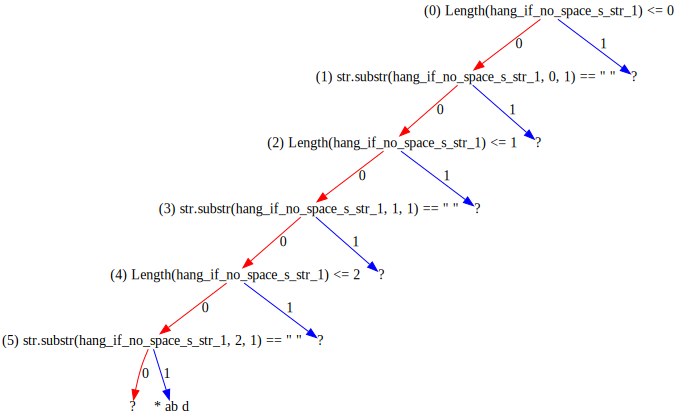

In [281]:
display_trace_tree(scf.ct.root)

For example, the pattern `00000:0` corresponds to the following predicates.

In [282]:
scf.ct.leaves['00000:0']

PlausibleChild[00000:0]

In [283]:
scf.ct.leaves['00000:0'].path_expression()

[Not(Length(hang_if_no_space_s_str_1) <= 0),
 Not(str.substr(hang_if_no_space_s_str_1, 0, 1) == " "),
 Not(Length(hang_if_no_space_s_str_1) <= 1),
 Not(str.substr(hang_if_no_space_s_str_1, 1, 1) == " "),
 Not(Length(hang_if_no_space_s_str_1) <= 2),
 Not(str.substr(hang_if_no_space_s_str_1, 2, 1) == " ")]

Similarly the pattern `:1` corresponds to the following predicates.

In [284]:
scf.ct.leaves[':1']

PlausibleChild[:1]

In [285]:
scf.ct.leaves[':1'].path_expression()

[Length(hang_if_no_space_s_str_1) <= 0]

We can now generate the next input to be generated by looking for the a leaf that is incompletely explored. The idea is to collect all leaf nodes, and choose one at random.

In [286]:
class SimpleConcolicFuzzer(SimpleConcolicFuzzer):
    def add_trace(self, trace, s):
        self.ct.add_trace(trace, s)

    def next_choice(self):
        #lst = sorted(list(self.ct.leaves.keys()), key=len)
        c = random.choice(list(self.ct.leaves.keys()))
        #c = lst[0]
        return self.ct.leaves[c]

We use the `next_choice()` as follows.

In [287]:
scf = SimpleConcolicFuzzer()
scf.add_trace(_, 'ab d')
node = scf.next_choice()

In [288]:
node

PlausibleChild[0000:1]

In [289]:
node.path_expression()

[Not(Length(hang_if_no_space_s_str_1) <= 0),
 Not(str.substr(hang_if_no_space_s_str_1, 0, 1) == " "),
 Not(Length(hang_if_no_space_s_str_1) <= 1),
 Not(str.substr(hang_if_no_space_s_str_1, 1, 1) == " "),
 Length(hang_if_no_space_s_str_1) <= 2]

We get the next choice for exploration, and expand the path expression, and return it together with a context using `get_newpath()`

In [290]:
class SimpleConcolicFuzzer(SimpleConcolicFuzzer):
    def get_newpath(self):
        node = self.next_choice()
        path = node.path_expression()
        return path, node.cc()

In [291]:
scf = SimpleConcolicFuzzer()
scf.add_trace(_, 'abcd')
path, cc = scf.get_newpath()
path

[Length(hang_if_no_space_s_str_1) <= 0]

#### The fuzzing method

The `fuzz()` method simply generates new lists of predicates, and solves them to produce new inputs.

In [292]:
class SimpleConcolicFuzzer(SimpleConcolicFuzzer):
    def fuzz(self):
        if self.ct.root.children == {}:
            # a random value to generate comparisons. This would be
            # the initial value around which we explore with concolic
            # fuzzing.
            # str_len = random.randint(1,100)
            # return ' '*str_len
            return ' '
        for i in range(self.max_tries):
            path, last = self.get_newpath()
            s, v = zeval_smt(path, last, log=False)
            if s != 'sat':
                # raise Exception("Unexpected UNSAT")
                continue

            val = list(v.values())[0]
            elt, typ = val

            # make sure that we do not retry the tried paths
            # The tracer we add here is incomplete. This gets updated when
            # the add_trace is called from the concolic fuzzer context.
            # self.add_trace(ConcolicTracer((last.decls, path)), elt)
            if typ == 'Int':
                if len(elt) == 2 and elt[0] == '-':  # negative numbers are [-, x]
                    return -1*int(elt[1])
                return int(elt)
            elif typ == 'String':
                return elt
            return elt
        return None

### End of Excursion

To illustrate `SimpleConcolicFuzzer`, let us apply it on our example program `cgi_decode()` from the `Coverage` chapter. Note that we cannot use it directly as the hash lookups in `hex_values` can not be used for transferring constraints yet.

In [293]:
with ConcolicTracer() as _:
    _[cgi_decode]('a+c')

In [294]:
_.path

[0 < Length(cgi_decode_s_str_1),
 Not(str.substr(cgi_decode_s_str_1, 0, 1) == "+"),
 Not(str.substr(cgi_decode_s_str_1, 0, 1) == "%"),
 1 < Length(cgi_decode_s_str_1),
 str.substr(cgi_decode_s_str_1, 1, 1) == "+",
 2 < Length(cgi_decode_s_str_1),
 Not(str.substr(cgi_decode_s_str_1, 2, 1) == "+"),
 Not(str.substr(cgi_decode_s_str_1, 2, 1) == "%"),
 Not(3 < Length(cgi_decode_s_str_1))]

In [295]:
scf = SimpleConcolicFuzzer()
scf.add_trace(_, 'a+c')

The _trace tree_ shows the path conditions encountered so far. Any blue edge towards a "?" implies that there is a path not yet taken.

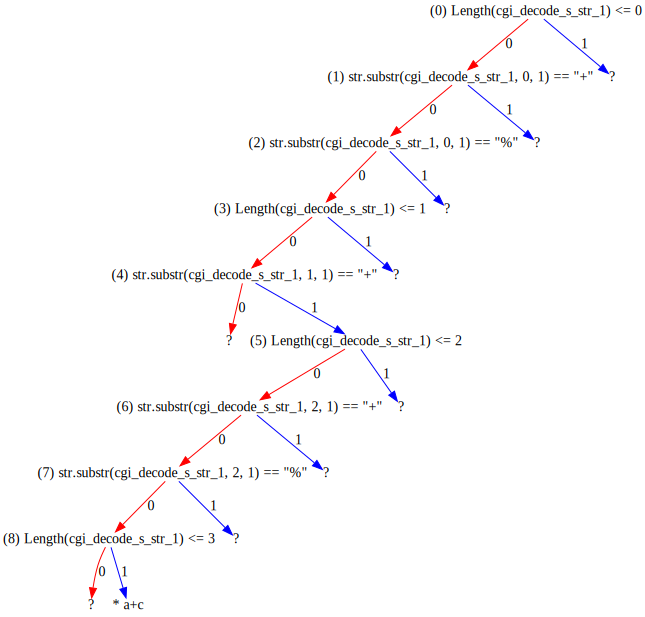

In [296]:
display_trace_tree(scf.ct.root)

So, we fuzz to get a new path that is not empty.

In [297]:
v = scf.fuzz()
print(v)

A+


We can now obtain the new trace as before.

In [298]:
with ExpectError():
    with ConcolicTracer() as _:
        _[cgi_decode](v)

The new trace is added to our fuzzer using `add_trace()`

In [299]:
scf.add_trace(_, v)

The updated binary tree is as follows. Note the difference between the child nodes of `Root` node.

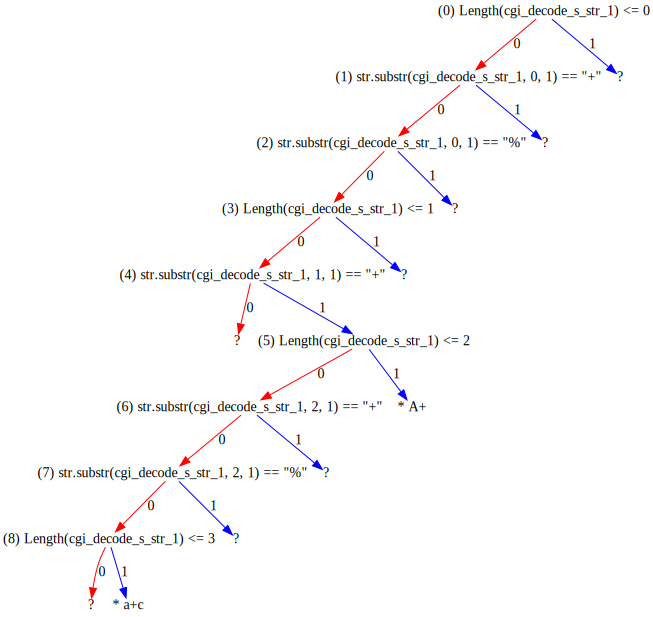

In [300]:
display_trace_tree(scf.ct.root)

A complete fuzzer run is as follows:

In [301]:
scf = SimpleConcolicFuzzer()
for i in range(10):
    v = scf.fuzz()
    print(repr(v))
    if v is None:
        continue
    with ConcolicTracer() as _:
        with ExpectError(print_traceback=False):
            # z3.StringVal(urllib.parse.unquote('%80')) <-- bug in z3
            _[cgi_decode](v)
    scf.add_trace(_, v)

' '
''
'+'
'%'
'+A'


IndexError: string index out of range (expected)


'++'
'AB'
'++A'
'A%'
'+AB'


IndexError: string index out of range (expected)


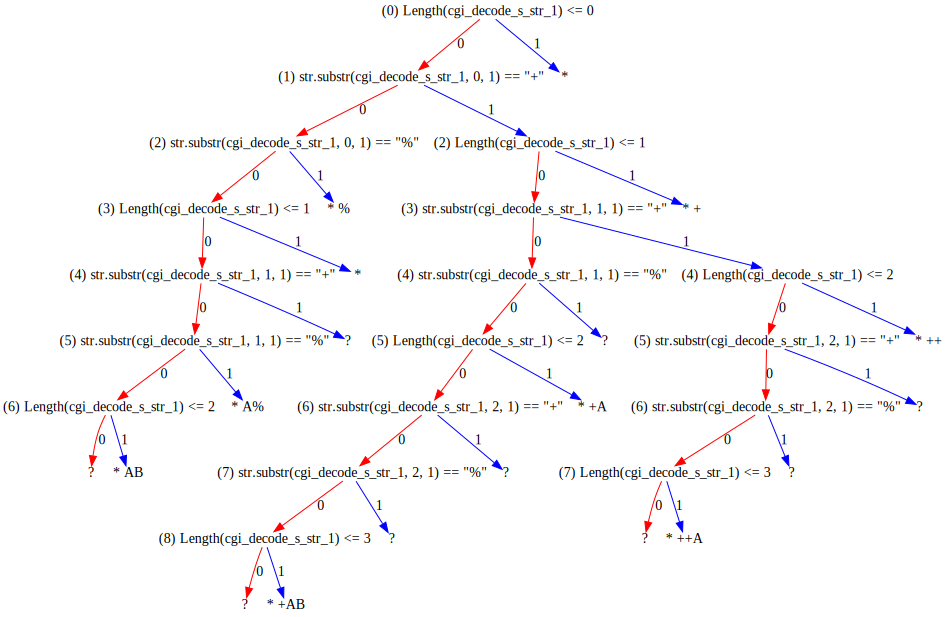

In [302]:
display_trace_tree(scf.ct.root)

**Note.** Our concolic tracer is limited in that it does not track changes in the string length. This leads it to treat every string with same prefix as the same string.

The `SimpleConcolicFuzzer` is reasonably efficient at exploring paths near the path followed by a given sample input. However, it is not very intelligent when it comes to choosing which paths to follow. We look at another fuzzer that lifts the predicates obtained to the grammar and achieves better fuzzing.

## Concolic Grammar Fuzzing

The concolic framework can be used directly in grammar-based fuzzing. We implement a class `ConcolicGrammarFuzzer` wihich does this.

### Excursion: Implementing ConcolicGrammarFuzzer

First, we extend our `GrammarFuzzer` with a helper method `tree_to_string()` such that we can retrieve the derivation tree of the fuzz output. We also define `prune_tree()` and `coalesce()` methods to reduce the depth of sub trees. These methods accept a list of tokens types such that a node belonging to the token type gets converted from a tree to a leaf node by calling `tree_to_string()`.

In [303]:
from InformationFlow import INVENTORY_GRAMMAR, SQLException

In [304]:
from GrammarFuzzer import GrammarFuzzer

In [305]:
class ConcolicGrammarFuzzer(GrammarFuzzer):
    def tree_to_string(self, tree):
        symbol, children, *_ = tree
        e = ''
        if children:
            return e.join([self.tree_to_string(c) for c in children])
        else:
            return e if symbol in self.grammar else symbol

    def prune_tree(self, tree, tokens):
        name, children = tree
        children = self.coalesce(children)
        if name in tokens:
            return (name, [(self.tree_to_string(tree), [])])
        else:
            return (name, [self.prune_tree(c, tokens) for c in children])

    def coalesce(self, children):
        last = ''
        new_lst = []
        for cn, cc in children:
            if cn not in self.grammar:
                last += cn
            else:
                if last:
                    new_lst.append((last, []))
                    last = ''
                new_lst.append((cn, cc))
        if last:
            new_lst.append((last, []))
        return new_lst

We can now use the fuzzer to produce inputs for our DB.

In [306]:
tgf = ConcolicGrammarFuzzer(INVENTORY_GRAMMAR)
while True:
    qtree = tgf.fuzz_tree()
    query = str(tgf.tree_to_string(qtree))
    if query.startswith('select'):
        break

In [307]:
from ExpectError import ExpectError

In [308]:
with ExpectError():
    print(repr(query))
    with ConcolicTracer() as _:
        res = _[db_select](str(query))
    print(repr(res))

'select t4(I,N)!=b(k)/O!=(K4(:/Z)) from I7'


Traceback (most recent call last):
  File "/var/folders/n2/xd9445p97rb3xh7m1dfx8_4h0006ts/T/ipykernel_15596/2536269233.py", line 4, in <module>
    res = _[db_select](str(query))
  File "/var/folders/n2/xd9445p97rb3xh7m1dfx8_4h0006ts/T/ipykernel_15596/2687284210.py", line 3, in __call__
    self.result = self.fn(*self.concolic(args))
  File "/var/folders/n2/xd9445p97rb3xh7m1dfx8_4h0006ts/T/ipykernel_15596/1994573112.py", line 4, in db_select
    r = my_db.sql(s)
  File "/Users/zeller/Projects/fuzzingbook/notebooks/InformationFlow.ipynb", line 65, in sql
    return method(query[len(key):])
  File "/Users/zeller/Projects/fuzzingbook/notebooks/InformationFlow.ipynb", line 84, in do_select
    _, table = self.table(t_name)
  File "/var/folders/n2/xd9445p97rb3xh7m1dfx8_4h0006ts/T/ipykernel_15596/2474817571.py", line 6, in table
    raise SQLException('Table (%s) was not found' % repr(t_name))
InformationFlow.SQLException: Table ('I7') was not found (expected)


Our fuzzer returns with an exception. It is unable to find the specified table. Let us examine the predicates it encountered.

In [309]:
for i, p in enumerate(_.path):
    print(i, p)

0 0 == IndexOf(db_select_s_str_1, "select ", 0)
1 0 == IndexOf(db_select_s_str_1, "select ", 0)
2 Not(0 >
    IndexOf(str.substr(db_select_s_str_1, 7, 34),
            " from ",
            0))
3 Not(34 <
    IndexOf(str.substr(db_select_s_str_1, 7, 34),
            " from ",
            0))
4 Or(0 <
   IndexOf(str.substr(db_select_s_str_1, 7, 34),
           " from ",
           0),
   0 ==
   IndexOf(str.substr(db_select_s_str_1, 7, 34),
           " from ",
           0))
5 Not(Or(0 <
       IndexOf(str.substr(db_select_s_str_1, 7, 34),
               " where ",
               0),
       0 ==
       IndexOf(str.substr(db_select_s_str_1, 7, 34),
               " where ",
               0)))
6 Not(34 <
    IndexOf(str.substr(db_select_s_str_1, 7, 34),
            " from ",
            0) +
    6)
7 Or(34 >
   IndexOf(str.substr(db_select_s_str_1, 7, 34),
           " from ",
           0) +
   6,
   34 ==
   IndexOf(str.substr(db_select_s_str_1, 7, 34),
           " from ",
          

Note that we can obtain constraints that are not present in the grammar from using the `ConcolicTracer`. In particular, see how we are able to obtain the condition that the table needs to be `inventory` (Predicate 11) for the fuzzing to succeed.

How do we lift these to the grammar? and in particular how do we do it automatically? One option we have is to simply switch the last predicate obtained. In our case, the last predicate is (11). Can we simply invert the predicate and solve it again?

In [310]:
new_path = _.path[0:-1] + [z3.Not(_.path[-1])]

In [311]:
new_ = ConcolicTracer((_.decls, new_path))
new_.fn = _.fn
new_.fn_args = _.fn_args

In [312]:
new_.zeval()

('No Solutions', None)

Indeed, this will not work as the string lengths being compared to are different.

In [313]:
print(_.path[-1])
z3.solve(z3.Not(_.path[-1]))

Not(str.substr(str.substr(db_select_s_str_1, 7, 34), 32, 2) ==
    "inventory")
no solution


A better idea is to investigate what _string_ comparisons are being made, and associate that with the corresponding nodes in the grammar. Let us examine our derivation tree (pruned to avoid recursive structures, and to focus on important parts).

In [314]:
from GrammarFuzzer import display_tree

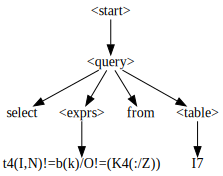

In [315]:
prune_tokens = [
    '<value>', '<table>', '<column>', '<literals>', '<exprs>', '<bexpr>'
]
dt = tgf.prune_tree(qtree, prune_tokens)
display_tree(dt)

Can we identify which part of the input was supplied by which part of the grammar? We define `span()` that can recover this information from the derivation tree. For a given node, let us assume that the start point is known. Then, for processing the children, we proceed as follows: We choose one child at a time from left to right, and compute the length of the child. The length of the children before the current child in addition to our starting point gives the starting point of the current child. The end point for each node is simply the end point of its last children (or the length of its node if it is a leaf).

In [316]:
from GrammarFuzzer import START_SYMBOL

In [317]:
def span(node, g, node_start=0):
    hm = {}
    k, cs = node
    end_i = node_start
    new_cs = []
    for c in cs:
        chm, (ck, child_start, child_end, gcs) = span(c, g, end_i)
        new_cs.append((ck, child_start, child_end, gcs))
        end_i = child_end
        hm.update(chm)
    node_end = end_i if cs else node_start + len(k)
    if k in g and k != START_SYMBOL:
        hm[k] = (node_start, node_end - node_start)
    return hm, (k, node_start, node_end, new_cs)

We use it as follows:

In [318]:
span_hm, _n = span(dt, INVENTORY_GRAMMAR)

In [319]:
span_hm

{'<exprs>': (7, 26), '<table>': (39, 2), '<query>': (0, 41)}

We can check if we got the right values as follows.

In [320]:
print("query:", query)
for k in span_hm:
    start, l = span_hm[k]
    print(k, query[start:start + l])

query: select t4(I,N)!=b(k)/O!=(K4(:/Z)) from I7
<exprs> t4(I,N)!=b(k)/O!=(K4(:/Z))
<table> I7
<query> select t4(I,N)!=b(k)/O!=(K4(:/Z)) from I7


Next, we need to obtain all the comparisons made in each predicate. For that, we define two helper functions. The first is `unwrap_substrings()` that translates multiple calls to `z3.SubString` and returns the start, and length of the given z3 string expression.

In [321]:
def unwrap_substrings(s):
    assert s.decl().name() == 'str.substr'
    cs, frm, l = s.children()
    fl = frm.as_long()
    ll = l.as_long()
    if cs.decl().name() == 'str.substr':
        newfrm, _l = unwrap_substrings(cs)
        return (fl + newfrm, ll)
    else:
        return (fl, ll)

We define `traverse_z3()` that traverses a given z3 string expression, and collects all direct string comparisons to a substring of the original argument.

In [322]:
def traverse_z3(p, hm):
    def z3_as_string(v):
        return v.as_string()

    n = p.decl().name()
    if n == 'not':
        return traverse_z3(p.children()[0], hm)
    elif n == '=':
        i, j = p.children()
        if isinstance(i, (int, z3.IntNumRef)):
            return traverse_z3(j, hm)
        elif isinstance(j, (int, z3.IntNumRef)):
            return traverse_z3(i, hm)
        else:
            if i.is_string() and j.is_string():
                if i.is_string_value():
                    cs, frm, l = j.children()
                    if (isinstance(frm, z3.IntNumRef)
                            and isinstance(l, z3.IntNumRef)):
                        hm[z3_as_string(i)] = unwrap_substrings(j)
                elif j.is_string_value():
                    cs, frm, l = i.children()
                    if (isinstance(frm, z3.IntNumRef)
                            and isinstance(l, z3.IntNumRef)):
                        hm[z3_as_string(j)] = unwrap_substrings(i)
            else:
                assert False  # for now
    elif n == '<' or n == '>':
        i, j = p.children()
        if isinstance(i, (int, z3.IntNumRef)):
            return traverse_z3(j, hm)
        elif isinstance(j, (int, z3.IntNumRef)):
            return traverse_z3(i, hm)
        else:
            assert False
    return p

In [323]:
comparisons: Dict[str, Tuple] = {}
for p in _.path:
    traverse_z3(p, comparisons)
comparisons

{'inventory': (39, 2)}

All that we need now is to declare string variables that match the substrings in `comparisons`, and solve for them for each item in the path. For that, we define `find_alternatives()`.

In [324]:
def find_alternatives(spans, cmp):
    alts = {}
    for key in spans:
        start, l = spans[key]
        rset = set(range(start, start + l))
        for ckey in cmp:
            cstart, cl = cmp[ckey]
            cset = set(range(cstart, cstart + cl))
            # if rset.issubset(cset): <- ignoring subsets for now.
            if rset == cset:
                if key not in alts:
                    alts[key] = set()
                alts[key].add(ckey)
    return alts

We use it as follows.

In [325]:
alternatives = find_alternatives(span_hm, comparisons)
alternatives

{'<table>': {'inventory'}}

So, we have our alternatives for each key in the grammar. We can now update our grammar as follows.

In [326]:
INVENTORY_GRAMMAR_NEW = dict(INVENTORY_GRAMMAR)

In [327]:
for k in alternatives:
    INVENTORY_GRAMMAR_NEW[k] = INVENTORY_GRAMMAR_NEW[k] + list(alternatives[k])

We made a choice here. We could have completely overwritten the definition of `<table>` . Instead, we added our new alternatives to the existing definition. This way, our fuzzer will also attempt other values for `<table>` once in a while.

In [328]:
INVENTORY_GRAMMAR_NEW['<table>']

['<word>', 'inventory']

Let us try fuzzing with our new grammar.

In [329]:
cgf = ConcolicGrammarFuzzer(INVENTORY_GRAMMAR_NEW)

In [330]:
for i in range(10):
    qtree = cgf.fuzz_tree()
    query = cgf.tree_to_string(qtree)
    print(query)
    with ExpectError(print_traceback=False):
        try:
            with ConcolicTracer() as _:
                res = _[db_select](query)
            print(repr(res))
        except SQLException as e:
            print(e)
        print()

insert into inventory (i9Oam41gsP2,h97,q8J:.70J) values ('.q')
Column ('i9Oam41gsP2') was not found

select C from wy where R/s/y>_-X-.+C/u==(((---6.5)))
Table ('wy') was not found

update T set I=gj5 where (-8.6/O*.-W)==s-O<Z((R),((N==(:))))
Table ('T') was not found

update inventory set f=o,V=Q6 where l0!=(((((-5)))==(rGJ)))
Column ('f') was not found

delete from j where T==5.58
Table ('j') was not found

insert into inventory (py75) values ('R','/','fd8g',3883.0)
Column ('py75') was not found

update inventory set GY5=X where G-g/z(w)<2.5
Column ('GY5') was not found

update nb0 set i=K,b=R,u=: where D>A
Table ('nb0') was not found

insert into inventory (P,wmE,U,F) values (50,'/',--6.2)
Column ('P') was not found

delete from GTV3_ where :-M!=t>n+R/x+r*a/t-r-V
Table ('GTV3_') was not found



That is, we were able to reach the dangerous method `my_eval()`.
In effect, what we have done is to lift parts of predicates to the grammar. The new grammar can generate inputs that reach deeper into the program than before. Note that we have only handled the equality predicate. One can also lift the '<' and '>' comparison operators to the grammar if required.

Compare the output of our fuzzer to the original `GrammarFuzzer` below.

In [331]:
gf = GrammarFuzzer(INVENTORY_GRAMMAR)
for i in range(10):
    query = gf.fuzz()
    print(query)
    with ExpectError(print_traceback=False):
        try:
            res = db_select(query)
            print(repr(res))
        except SQLException as e:
            print(e)
        print()

insert into UCu4 (E,xM:lOq6,u38p,W54G3b0) values (':',1.835)
Table ('UCu4') was not found

insert into B81 (Np) values ('h')
Table ('B81') was not found

delete from w where Xn((T))>a(8.8,g)/h+t-P-j+L
Table ('w') was not found

update q75 set L=z4 where ((QUy+N))==A/P-L*ao(R)/I
Table ('q75') was not found

update q3 set x=F where l(N)-P-S+t==e
Table ('q3') was not found

update Dy06rr set h=F where (z!=Q)==(((a<q)))
Table ('Dy06rr') was not found

delete from Z where V(7)>a==O(mA,j(g)*:,s,B)-5-eD(c,F!=n)==eO41Xy
Table ('Z') was not found

select 1.8 from U3X8p
Table ('U3X8p') was not found

update N set w=X9,A=w,M=Z where ((b!=c))==U/N<I
Table ('N') was not found

insert into I1 (g,_Q,y8e0) values (5.7,'.&',05.2)
Table ('I1') was not found



As can be seen, the original grammar fuzzer is unable to proceed beyond the table verification.

#### Pruning and Updating

We implement these methods in `ConcolicGrammarFuzzer`. The method `update_grammar()` allows `ConcolicGrammarFuzzer` to collect feedback from concolic fuzzing, and update the grammar used for fuzzing accordingly.

In [332]:
class ConcolicGrammarFuzzer(ConcolicGrammarFuzzer):
    def prune_tokens(self, tokens):
        self.prune_tokens = tokens

    def update_grammar(self, trace):
        self.comparisons = {}
        for p in trace.path:
            traverse_z3(p, self.comparisons)
        alternatives = find_alternatives(self.span_range, self.comparisons)
        if self.log:
            print('Alternatives:', alternatives, 'Span:', self.span_range)
        new_grammar = dict(self.grammar)
        for k in alternatives:
            new_grammar[k] = list(set(new_grammar[k] + list(alternatives[k])))
        self.grammar = new_grammar

The `fuzz()` method simply generates the derivation tree, computes the span range, and returns the string generated from the derivation tree.

In [333]:
class ConcolicGrammarFuzzer(ConcolicGrammarFuzzer):
    def fuzz(self):
        qtree = self.fuzz_tree()
        self.pruned_tree = self.prune_tree(qtree, self.prune_tokens)
        query = self.tree_to_string(qtree)
        self.span_range, _n = span(self.pruned_tree, self.grammar)
        return query

To ensure that our approach works, let us update our tables slightly.

In [334]:
inventory = db.db.pop('inventory', None)

In [335]:
db.db['vehicles'] = inventory
db.db['months'] = ({
    'month': int,
    'name': str
}, [{
    'month': i + 1,
    'name': m
} for i, m in enumerate([
    'jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct',
    'nov', 'dec'
])])
db.db

{'vehicles': ({'year': int, 'kind': str, 'company': str, 'model': str},
  [{'year': 1997, 'kind': 'van', 'company': 'Ford', 'model': 'E350'},
   {'year': 2000, 'kind': 'car', 'company': 'Mercury', 'model': 'Cougar'},
   {'year': 1999, 'kind': 'car', 'company': 'Chevy', 'model': 'Venture'}]),
 'months': ({'month': int, 'name': str},
  [{'month': 1, 'name': 'jan'},
   {'month': 2, 'name': 'feb'},
   {'month': 3, 'name': 'mar'},
   {'month': 4, 'name': 'apr'},
   {'month': 5, 'name': 'may'},
   {'month': 6, 'name': 'jun'},
   {'month': 7, 'name': 'jul'},
   {'month': 8, 'name': 'aug'},
   {'month': 9, 'name': 'sep'},
   {'month': 10, 'name': 'oct'},
   {'month': 11, 'name': 'nov'},
   {'month': 12, 'name': 'dec'}])}

### End of Excursion

The `ConcolicGrammarFuzzer` is used as follows.

In [336]:
cgf = ConcolicGrammarFuzzer(INVENTORY_GRAMMAR)
cgf.prune_tokens(prune_tokens)
for i in range(10):
    query = cgf.fuzz()
    print(query)
    with ConcolicTracer() as _:
        with ExpectError(print_traceback=False):
            try:
                res = _[db_select](query)
                print(repr(res))
            except SQLException as e:
                print(e)
        cgf.update_grammar(_)
        print()

select Qq6L,(X) from LYg0 where ((x<w))!=(A)
Table ('LYg0') was not found

update a set P3=_ where p/h-g-Z<l-Q(U)
Table ('a') was not found

select W,H,s from vehicles where I+N/S+k/R!=G2

insert into months (S,q1i) values (7.3,'3[s=K=','e')
Column ('S') was not found

delete from vehicles where v-f*r/s/q>h-K-m(n,X)
Invalid WHERE ('v-f*r/s/q>h-K-m(n,X)')

select C*R*Y(A)/Z<J,(q)!=:(R),D from C
Table ('C') was not found

delete from months where K-t/W(E)-Y+A<H+I*U+w
Invalid WHERE ('K-t/W(E)-Y+A<H+I*U+w')

select e*L*G-A/_ from _3 where (G)==B(F,H)
Table ('_3') was not found

select S(Y)<c,PF(j),h,s,_ from vehicles
Invalid WHERE ('(S(Y)<c,PF(j),h,s,_)')

update e set m=:LMG where 6.48!=A+C-l+c<K(_)*f/o+h==H
Table ('e') was not found



TypeError: 'NotImplementedType' object is not callable (expected)


As can be seen, the fuzzer starts with no knowledge of the tables `vehicles`, `months` and `years`, but identifies it from the concolic execution, and lifts it to the grammar. This allows us to improve the effectiveness of fuzzing.

## Limitations

As with dynamic taint analysis, implicit control flow can obscure the predicates encountered during concolic execution. However, this limitation could be overcome to some extent by wrapping any constants in the source with their respective proxy objects. Similarly, calls to internal C functions can cause the symbolic information to be discarded, and only partial information may be obtained.

## Synopsis

This chapter defines two main classes: `SimpleConcolicFuzzer` and `ConcolicGrammarFuzzer`. The `SimpleConcolicFuzzer` first uses a sample input to collect predicates encountered. The fuzzer then negates random predicates to generate new input constraints. These, when solved, produce inputs that explore paths that are close to the original path.

### ConcolicTracer

At the heart of both fuzzers lies the concept of a _concolic tracer_, capturing symbolic variables and path conditions as a program gets executed.

`ConcolicTracer` is used in a `with` block; the syntax `tracer[function]` executes `function` within the `tracer` while capturing conditions. Here is an example for the `cgi_decode()` function:

In [337]:
with ConcolicTracer() as _:
    _[cgi_decode]('a%20d')

Once executed, we can retrieve the symbolic variables in the `decls` attribute. This is a mapping of symbolic variables to types.

In [338]:
_.decls

{'cgi_decode_s_str_1': 'String'}

The extracted path conditions can be found in the `path` attribute:

In [339]:
_.path

[0 < Length(cgi_decode_s_str_1),
 Not(str.substr(cgi_decode_s_str_1, 0, 1) == "+"),
 Not(str.substr(cgi_decode_s_str_1, 0, 1) == "%"),
 1 < Length(cgi_decode_s_str_1),
 Not(str.substr(cgi_decode_s_str_1, 1, 1) == "+"),
 str.substr(cgi_decode_s_str_1, 1, 1) == "%",
 Not(str.substr(cgi_decode_s_str_1, 2, 1) == "0"),
 Not(str.substr(cgi_decode_s_str_1, 2, 1) == "1"),
 str.substr(cgi_decode_s_str_1, 2, 1) == "2",
 str.substr(cgi_decode_s_str_1, 3, 1) == "0",
 4 < Length(cgi_decode_s_str_1),
 Not(str.substr(cgi_decode_s_str_1, 4, 1) == "+"),
 Not(str.substr(cgi_decode_s_str_1, 4, 1) == "%"),
 Not(5 < Length(cgi_decode_s_str_1))]

The `context` attribute holds a pair of `decls` and `path` attributes; this is useful for passing it into the `ConcolicTracer` constructor.

In [340]:
assert _.context == (_.decls, _.path)

We can solve these constraints to obtain a value for the function parameters that follow the same path as the original (traced) invocation:

In [341]:
_.zeval()

('sat', {'s': ('A%20B', 'String')})

The `zeval()` function also allows to pass _alternate_ or _negated_ constraints. See the chapter for examples.

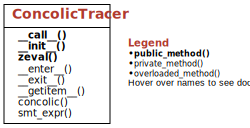

In [342]:
# ignore
from ClassDiagram import display_class_hierarchy
display_class_hierarchy(ConcolicTracer)

### SimpleConcolicFuzzer

The constraints obtained from `ConcolicTracer` are added to the concolic fuzzer as follows:

In [343]:
scf = SimpleConcolicFuzzer()
scf.add_trace(_, 'a%20d')

The concolic fuzzer then uses the constraints added to guide its fuzzing as follows:

In [344]:
scf = SimpleConcolicFuzzer()
for i in range(20):
    v = scf.fuzz()
    if v is None:
        break
    print(repr(v))
    with ExpectError(print_traceback=False):
        with ConcolicTracer() as _:
            _[cgi_decode](v)
    scf.add_trace(_, v)

' '
'%'
'AB'
''
'ABC'


IndexError: string index out of range (expected)


'A'
'AB+'
'AB'
'ABCD'
'ABC+'
'A'
'ABC'
'ABC%'


IndexError: string index out of range (expected)
IndexError: string index out of range (expected)


'A%'
'ABC+DE'
'AB'
'AB+'
'A'
'ABCD'
'A'


We see how the additional inputs generated explore additional paths.

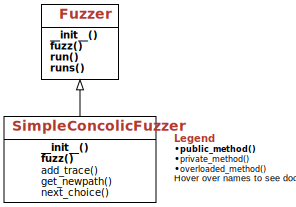

In [345]:
# ignore
display_class_hierarchy(SimpleConcolicFuzzer)

### ConcolicGrammarFuzzer

The `SimpleConcolicFuzzer` simply explores all paths near the original path traversed by the sample input. It uses a simple mechanism to explore the paths that are near the paths that it knows about, and other than code paths, knows nothing about the input.

The `ConcolicGrammarFuzzer` on the other hand, knows about the input grammar, and can collect feedback from the subject under fuzzing. It can lift some of the constraints encountered to the grammar, enabling deeper fuzzing. It is used as follows:

In [346]:
from InformationFlow import INVENTORY_GRAMMAR, SQLException

In [347]:
cgf = ConcolicGrammarFuzzer(INVENTORY_GRAMMAR)
cgf.prune_tokens(prune_tokens)
for i in range(10):
    query = cgf.fuzz()
    print(query)
    with ConcolicTracer() as _:
        with ExpectError(print_traceback=False):
            try:
                res = _[db_select](query)
                print(repr(res))
            except SQLException as e:
                print(e)
        cgf.update_grammar(_)
        print()

insert into W (Ru_2,.Wj186518W8) values ('@','}','h')
Table ('W') was not found

select S>R(j),A from C3 where U4==9249
Table ('C3') was not found

select I/I*U/n1(M),T/E*d(S) from vehicles
Invalid WHERE ('(I/I*U/n1(M),T/E*d(S))')

select (v==X),t,h,E from months where r8(w)<D-e

select e!=K,X from a25i where G/S-y<h/P
Table ('a25i') was not found

select C,: from months where s*u!=W(Y)>B/P(g)

select x/z+.(L)-h from months where -9!=Y>G(A)

delete from h4OB60J where K-w/M<t*N/A*S
Table ('h4OB60J') was not found

delete from months where r/v+z*Y+A-k<(q<h)+y
Invalid WHERE ('r/v+z*Y+A-k<(q<h)+y')

select (V==b),(C>A) from vehicles where B(e,R)>D



TypeError: 'NotImplementedType' object is not callable (expected)
TypeError: 'NotImplementedType' object is not callable (expected)
TypeError: 'NotImplementedType' object is not callable (expected)
TypeError: 'NotImplementedType' object is not callable (expected)


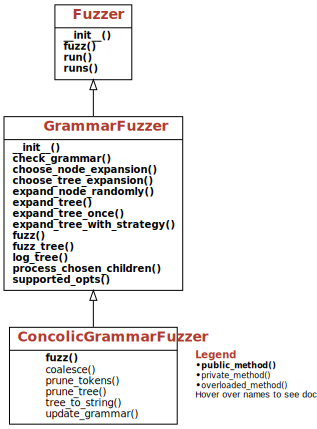

In [348]:
# ignore
display_class_hierarchy(ConcolicGrammarFuzzer)

## Lessons Learned

* Concolic execution can often provide more information than taint analysis with respect to the program behavior. However, this comes at a much larger runtime cost. Hence, unlike taint analysis, real-time analysis is often not possible.

* Similar to taint analysis, concolic execution also suffers from limitations such as indirect control flow and internal function calls.

* Predicates from concolic execution can be used in conjunction with fuzzing to provide an even more robust indication of incorrect behavior than taints, and can be used to create grammars that are better at producing valid inputs.

## Next Steps

A costlier but stronger alternative to concolic fuzzing is [symbolic fuzzing](SymbolicFuzzer.ipynb). Similarly, [search based fuzzing](SearchBasedFuzzer.ipynb) can often provide a cheaper exploration strategy than relying on SMT solvers to provide inputs slightly different from the current path.

## Background

The technique of concolic execution was originally used to inform and expand the scope of _symbolic execution_ \cite{king1976symbolic}, a static analysis technique for program analysis. Laron et al. cite{Larson2003} was the first to use the concolic execution technique.

The idea of using proxy objects for collecting constraints was pioneered by Cadar et al. \cite{cadar2005execution}. The concolic execution technique for Python programs used in this chapter was pioneered by PeerCheck \cite{PeerCheck}, and Python Error Finder \cite{Barsotti2018}.

## Exercises

### Exercise 1: Implment a Concolic Float Proxy Class


While implementing the `zint` binary operators, we asserted that the results were `int`. However, that need not be the case. For example, division can result in `float`. Hence, we need proxy objects for `float`. Can you implement a similar proxy object for `float` and fix the `zint` binary operator definition?

__Solution.__ The solution is as follows.

As in the case of `zint`, we first open up `zfloat` for extension.

In [349]:
class zfloat(float):
    def __new__(cls, context, zn, v, *args, **kw):
        return float.__new__(cls, v, *args, **kw)

We then implement the initialization methods.

In [350]:
class zfloat(zfloat):
    @classmethod
    def create(cls, context, zn, v=None):
        return zproxy_create(cls, 'Real', z3.Real, context, zn, v)

    def __init__(self, context, z, v=None):
        self.z, self.v = z, v
        self.context = context

The helper for when one of the arguments in a binary operation is not `float`.

In [351]:
class zfloat(zfloat):
    def _zv(self, o):
        return (o.z, o.v) if isinstance(o, zfloat) else (z3.RealVal(o), o)

Coerce `float` into bool value for use in conditionals.

In [352]:
class zfloat(zfloat):
    def __bool__(self):
        # force registering boolean condition
        if self != 0.0:
            return True
        return False

Define the common proxy method for comparison methods

In [353]:
def make_float_bool_wrapper(fname, fun, zfun):
    def proxy(self, other):
        z, v = self._zv(other)
        z_ = zfun(self.z, z)
        v_ = fun(self.v, v)
        return zbool(self.context, z_, v_)

    return proxy

We apply the comparison methods on the defined `zfloat` class.

In [354]:
FLOAT_BOOL_OPS = [
    '__eq__',
    # '__req__',
    '__ne__',
    # '__rne__',
    '__gt__',
    '__lt__',
    '__le__',
    '__ge__',
]

In [355]:
for fname in FLOAT_BOOL_OPS:
    fun = getattr(float, fname)
    zfun = getattr(z3.ArithRef, fname)
    setattr(zfloat, fname, make_float_bool_wrapper(fname, fun, zfun))

Similarly, we define the common proxy method for binary operators.

In [356]:
def make_float_binary_wrapper(fname, fun, zfun):
    def proxy(self, other):
        z, v = self._zv(other)
        z_ = zfun(self.z, z)
        v_ = fun(self.v, v)
        return zfloat(self.context, z_, v_)

    return proxy

And apply them on `zfloat`

In [357]:
FLOAT_BINARY_OPS = [
    '__add__',
    '__sub__',
    '__mul__',
    '__truediv__',
    # '__div__',
    '__mod__',
    # '__divmod__',
    '__pow__',
    # '__lshift__',
    # '__rshift__',
    # '__and__',
    # '__xor__',
    # '__or__',
    '__radd__',
    '__rsub__',
    '__rmul__',
    '__rtruediv__',
    # '__rdiv__',
    '__rmod__',
    # '__rdivmod__',
    '__rpow__',
    # '__rlshift__',
    # '__rrshift__',
    # '__rand__',
    # '__rxor__',
    # '__ror__',
]

In [358]:
for fname in FLOAT_BINARY_OPS:
    fun = getattr(float, fname)
    zfun = getattr(z3.ArithRef, fname)
    setattr(zfloat, fname, make_float_binary_wrapper(fname, fun, zfun))

These are used as follows.

In [359]:
with ConcolicTracer() as _:
    za = zfloat.create(_.context, 'float_a', 1.0)
    zb = zfloat.create(_.context, 'float_b', 0.0)
    if za * zb:
        print(1)

In [360]:
_.context

({'float_a': 'Real', 'float_b': 'Real'}, [Not(float_a*float_b != 0)])

Finally, we fix the `zint` binary wrapper to correctly create `zfloat` when needed.

In [361]:
def make_int_binary_wrapper(fname, fun, zfun):  # type: ignore
    def proxy(self, other):
        z, v = self._zv(other)
        z_ = zfun(self.z, z)
        v_ = fun(self.v, v)
        if isinstance(v_, float):
            return zfloat(self.context, z_, v_)
        elif isinstance(v_, int):
            return zint(self.context, z_, v_)
        else:
            assert False

    return proxy

In [362]:
for fname in INT_BINARY_OPS:
    fun = getattr(int, fname)
    zfun = getattr(z3.ArithRef, fname)
    setattr(zint, fname, make_int_binary_wrapper(fname, fun, zfun))

Checking whether it worked as expected.

In [363]:
with ConcolicTracer() as _:
    v = _[binomial](4, 2)

In [364]:
_.zeval()

('sat', {'n': ('4', 'Int'), 'k': ('2', 'Int')})

### Exercise 2: Bit Manipulation

Similar to floats, implementing the bit manipulation functions such as `xor` involves converting `int` to its bit vector equivalents, performing operations on them, and converting it back to the original type. Can you implement the bit manipulation operations for `zint`?

__Solution.__ The solution is as follows.

We first define the proxy method as before.

In [365]:
def make_int_bit_wrapper(fname, fun, zfun):
    def proxy(self, other):
        z, v = self._zv(other)
        z_ = z3.BV2Int(
            zfun(
                z3.Int2BV(
                    self.z, num_bits=64), z3.Int2BV(
                    z, num_bits=64)))
        v_ = fun(self.v, v)
        return zint(self.context, z_, v_)

    return proxy

It is then applied to the `zint` class.

In [366]:
BIT_OPS = [
    '__lshift__',
    '__rshift__',
    '__and__',
    '__xor__',
    '__or__',
    '__rlshift__',
    '__rrshift__',
    '__rand__',
    '__rxor__',
    '__ror__',
]

In [367]:
def init_concolic_4():
    for fname in BIT_OPS:
        fun = getattr(int, fname)
        zfun = getattr(z3.BitVecRef, fname)
        setattr(zint, fname, make_int_bit_wrapper(fname, fun, zfun))

In [368]:
INITIALIZER_LIST.append(init_concolic_4)

In [369]:
init_concolic_4()

Invert is the only unary bit manipulation method.

In [370]:
class zint(zint):
    def __invert__(self):
        return zint(self.context, z3.BV2Int(
            ~z3.Int2BV(self.z, num_bits=64)), ~self.v)

The `my_fn()` computes `xor` and returns `True` if the `xor` results in a non zero value.

In [371]:
def my_fn(a, b):
    o_ = (a | b)
    a_ = (a & b)
    if o_ & ~a_:
        return True
    else:
        return False

Using that under `ConcolicTracer`

In [372]:
with ConcolicTracer() as _:
    print(_[my_fn](2, 1))

True


We log the computed SMT expression to verify that everything went well.

In [373]:
_.zeval(log=True)

Predicates in path:
0 0 !=
BV2Int(int2bv(BV2Int(int2bv(my_fn_a_int_1) |
                     int2bv(my_fn_b_int_2))) &
       int2bv(BV2Int(~int2bv(BV2Int(int2bv(my_fn_a_int_1) &
                                    int2bv(my_fn_b_int_2))))))

(declare-const my_fn_a_int_1 Int)
(declare-const my_fn_b_int_2 Int)
(assert (let ((a!1 (bvnot (bvor (bvnot ((_ int2bv 64) my_fn_a_int_1))
                        (bvnot ((_ int2bv 64) my_fn_b_int_2))))))
(let ((a!2 (bvor (bvnot (bvor ((_ int2bv 64) my_fn_a_int_1)
                              ((_ int2bv 64) my_fn_b_int_2)))
                 a!1)))
  (not (= 0 (bv2int (bvnot a!2)))))))
(check-sat)
(get-model)

z3 -t:6000 /var/folders/n2/xd9445p97rb3xh7m1dfx8_4h0006ts/T/tmpbj7uryp8.smt
sat
(
  (define-fun my_fn_a_int_1 () Int
    (- 1))
  (define-fun my_fn_b_int_2 () Int
    (- 9223372036854775809))
)


('sat', {'a': (['-', '1'], 'Int'), 'b': (['-', '9223372036854775809'], 'Int')})

We can confirm from the formulas generated that the bit manipulation functions worked correctly. 

### Exercise 3: String Translation Functions

We have seen how to define `upper()` and `lower()`. Can you define the `capitalize()`, `title()`, and `swapcase()` methods?

__Solution.__ Solution not yet available.